In [1]:
%load_ext lab_black

In [2]:
import os
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import xarray as xr
from cmcrameri import cm
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
from scipy.optimize import differential_evolution
from sklearn import preprocessing

sys.path.append("../")
from cfg.convert_cfg_to_yaml import save_myyaml_from_mycfg
from Data import Data_eval
import Data
from include.loss import pixel_weighted_cross_entropy
import model_eval
import models.reg as rm
import seaborn as sns
from sklearn.inspection import permutation_importance
import itertools

import matplotlib_functions as mympf

pd.set_option("display.float_format", lambda x: "%.1f" % x)

mympf.setMatplotlibParam()
plt.viridis()

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/weights"
dir_plots = "paper-inv"

dir_res_lip = os.path.join(dir_res, "lip")
dir_res_box = os.path.join(dir_res, "box")
dir_res_tur = os.path.join(dir_res, "tur")

2023-06-16 13:31:25.891858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 1920x1440 with 0 Axes>

# Dataset: fields description

In [41]:
path_ds = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
ds = xr.open_dataset(path_ds)

In [133]:
mympf.setMatplotlibParam_singlefig()
plt.viridis()

<Figure size 1200x900 with 0 Axes>

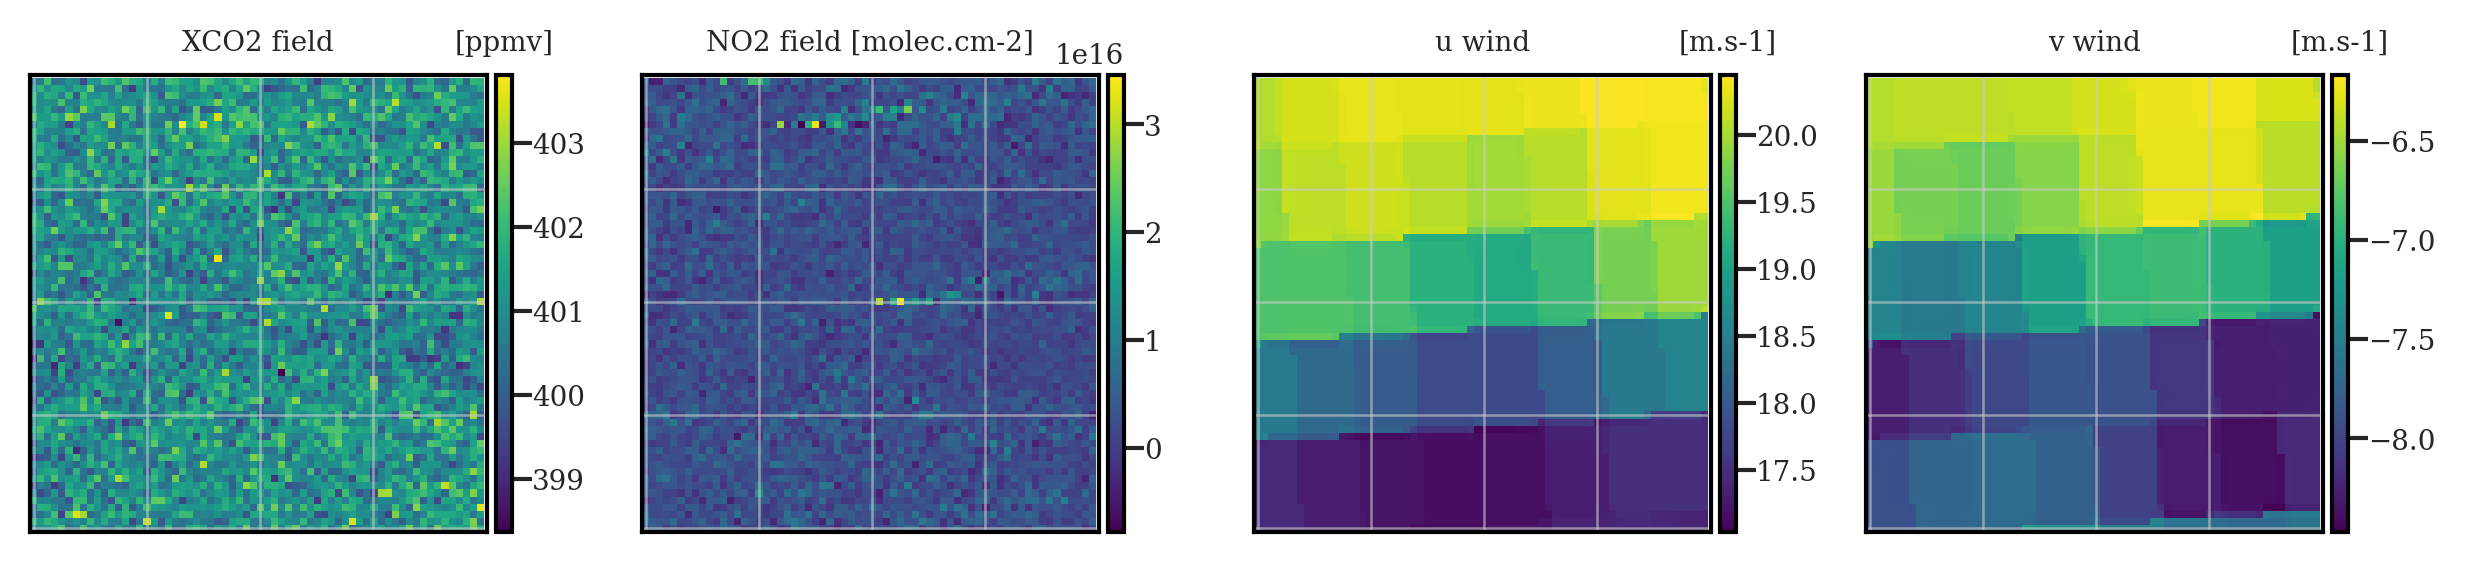

In [62]:
idx = 50
axs = mympf.set_figure_axs(
    1,
    4,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.01,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)


xco2 = data.ds.xco2 + 0.7 * np.random.randn(*data.ds.xco2.shape)
im = axs[0].imshow(np.squeeze(xco2[idx, :, :]), origin="lower")
cax = axs[0].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
cbar.ax.set_title("[ppmv]")
axs[0].set_title("XCO2 field")


no2 = data.ds.no2 + np.random.randn(*data.ds.no2.shape) * data.ds.no2
im =  axs[1].imshow(np.squeeze(no2[idx, :, :]), origin="lower")
cax = axs[1].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
axs[1].set_title("NO2 field [molec.cm-2]")


u_wind = data.ds.u
im = axs[2].imshow(np.squeeze(u_wind[idx, :, :]), origin="lower")
cax = axs[2].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
cbar.ax.set_title("[m.s-1]")
axs[2].set_title("u wind")


v_wind = data.ds.v
im = axs[3].imshow(np.squeeze(v_wind[idx, :, :]), origin="lower")
cax = axs[3].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
cbar.ax.set_title("[m.s-1]")
axs[3].set_title("v wind")

Ny = int(xco2.shape[1])
Nx = int(xco2.shape[2])
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.savefig(os.path.join(dir_plots, "data_inputs_lip_example.pdf"), transparent=True)

# Segmentation

In [6]:
# Turow
name_model = "/cerea_raid/users/dumontj/dev/coco2/dl/res/segmentation/seg_tur"
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Tur/train_dataset.nc"

In [7]:
data = model_eval.get_data_for_segmentation(
    name_model,
    path_eval_nc,
)

model = model_eval.get_segmentation_model(
    name_model, name_w="w_best.h5"
)

data.y.train.shape (6289, 64, 64, 1)


2023-04-25 13:07:53.075476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 13:07:53.659053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14410 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [8]:
wbce = model_eval.get_wbce_model_on_data(model, data)
print(np.mean(wbce))
nwbce = model_eval.get_nwbce_model_on_data(model, data)
print(np.mean(nwbce))

2023-04-25 13:07:55.887944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-25 13:07:56.674483: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


197/197 [==============================] - 4s 8ms/step
0.14069693
197/197 [==============================] - 1s 7ms/step
0.5578646


nwbce: 0.28791454434394836
idx: 77
origin: smart_2km_Tur_64
time: 2015-01-08T05:00:00.000000000
emiss: [9.033682 8.016872 8.129713]

nwbce: 0.39261290431022644
idx: 1556
origin: smart_2km_Tur_64
time: 2015-03-30T20:00:00.000000000
emiss: [ 9.840071 10.03323  10.61207 ]

nwbce: 0.7199615240097046
idx: 5359
origin: smart_2km_Tur_64
time: 2015-10-31T07:00:00.000000000
emiss: [8.391708 6.216371 5.516638]



<Figure size 1920x1440 with 0 Axes>

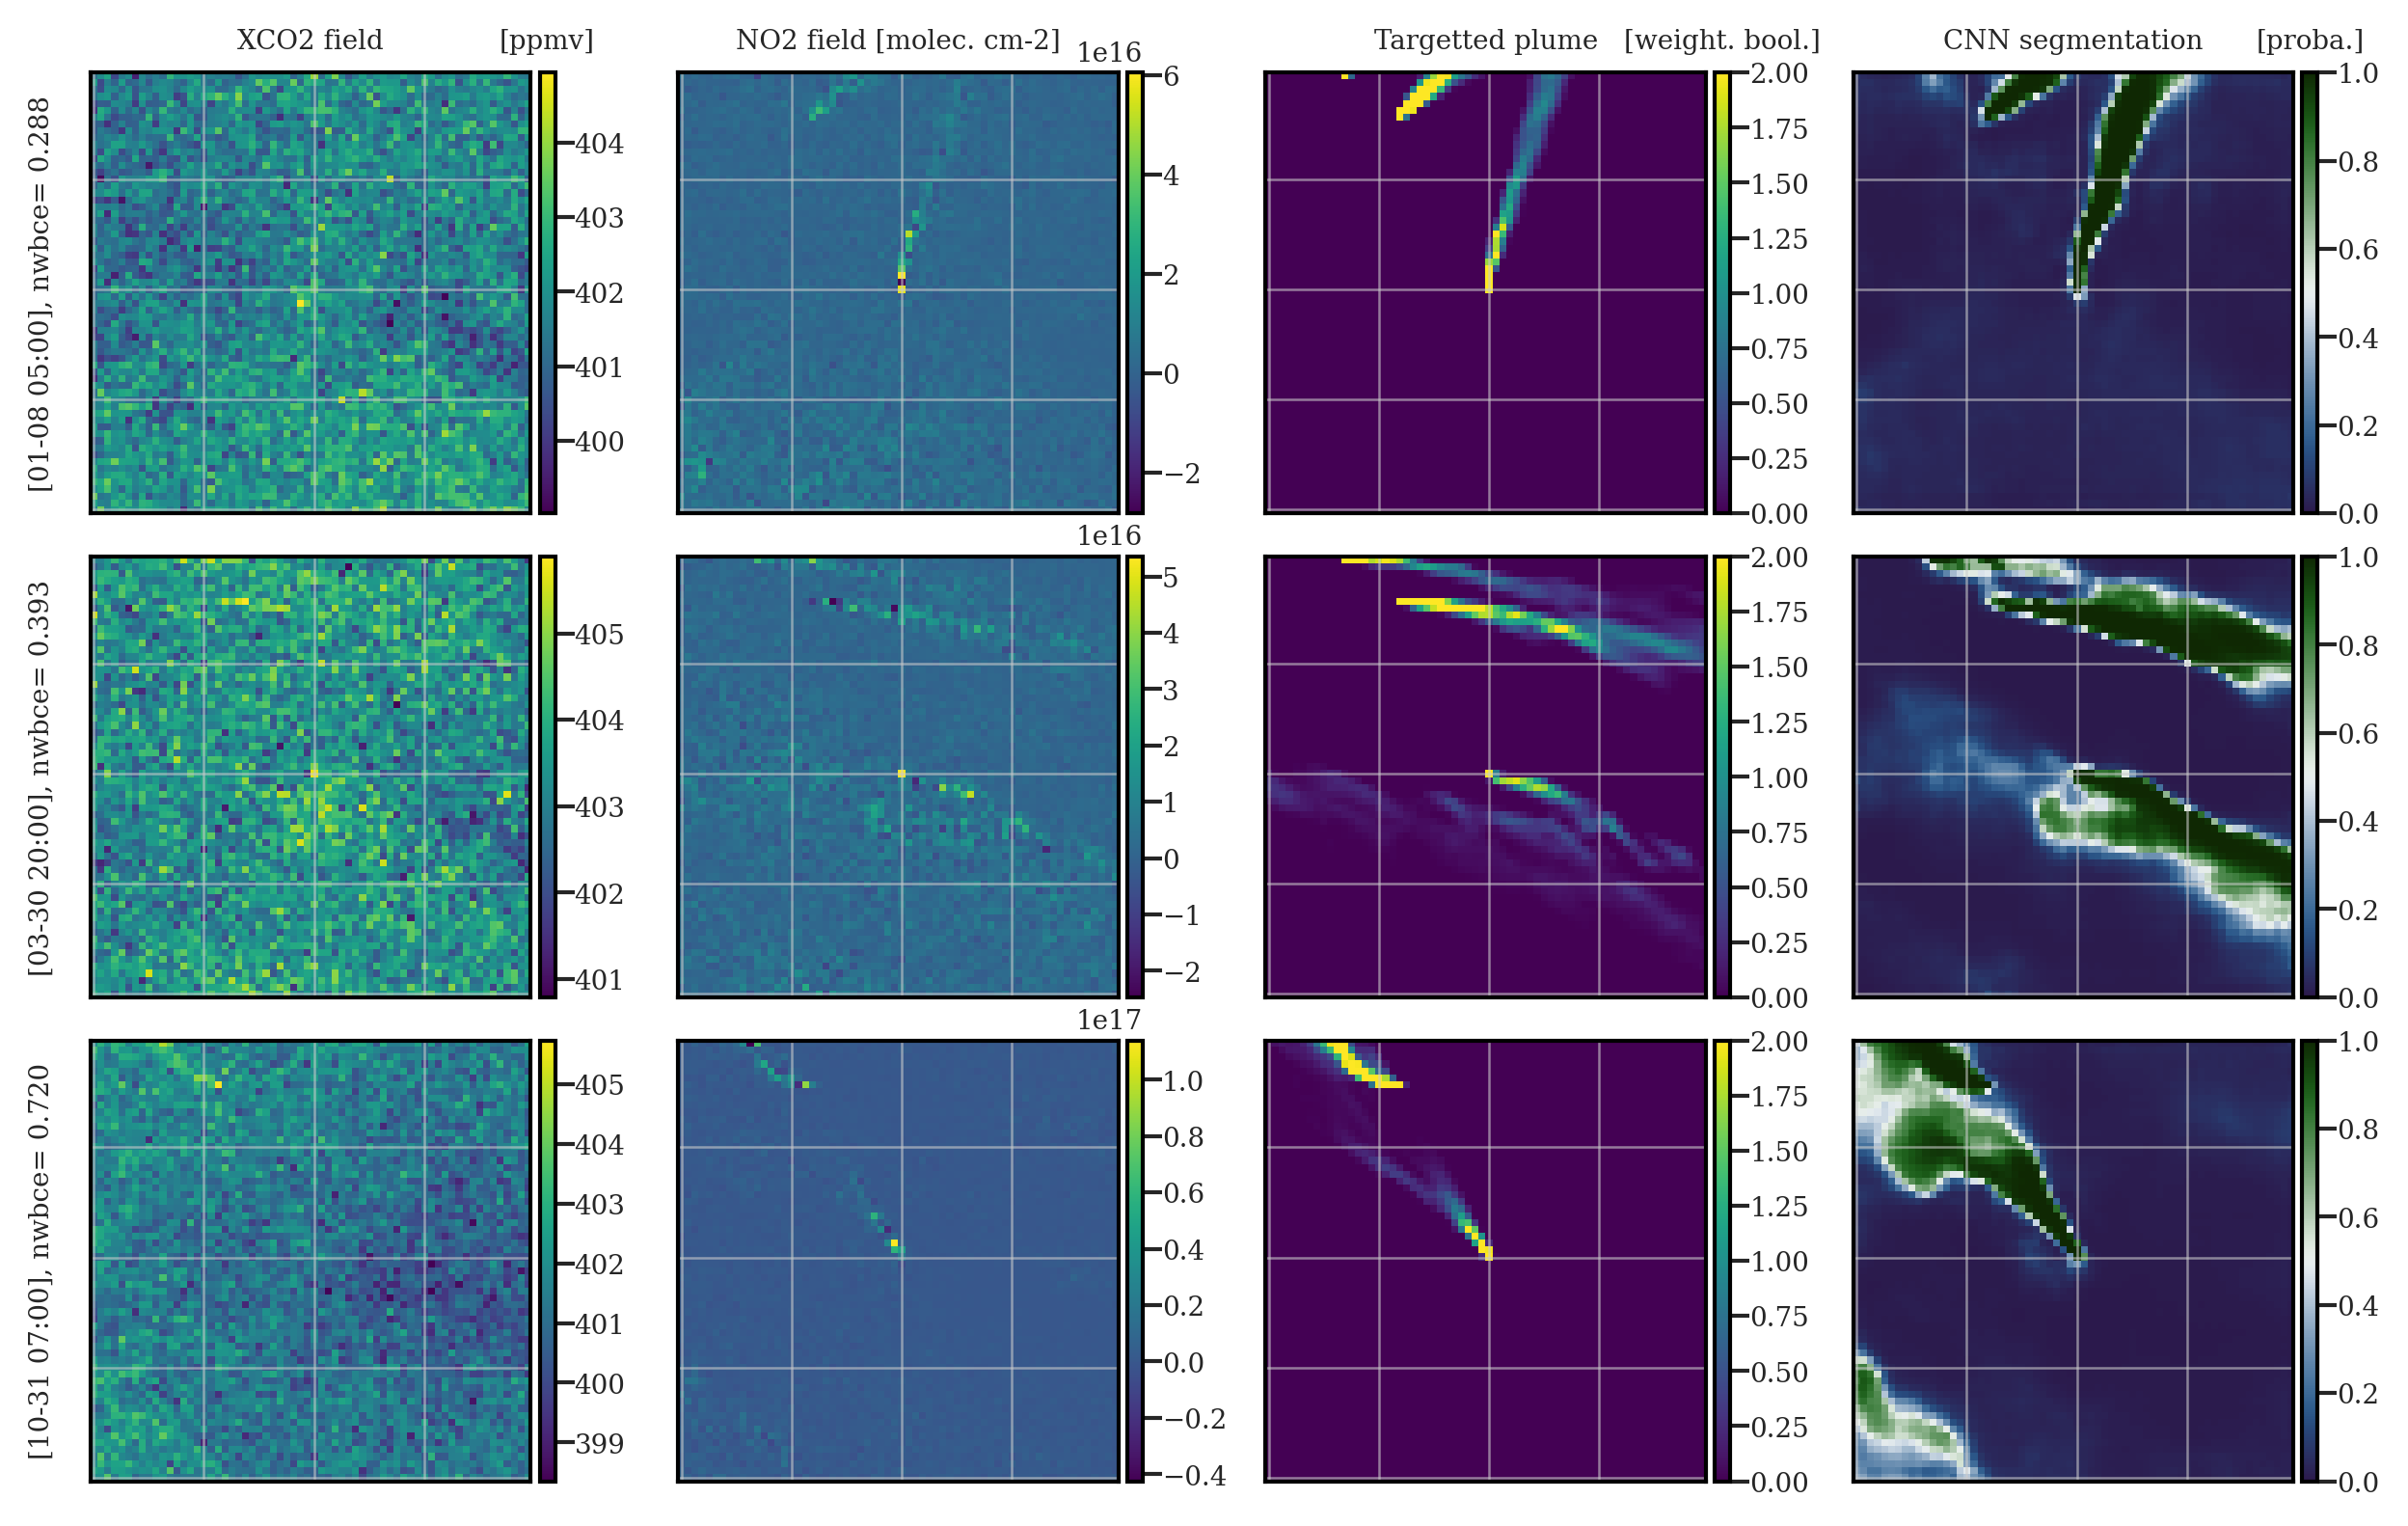

In [40]:
[idx0, ds_idx0] = model_eval.draw_idx(nwbce, data.ds, interval = [0.125,0.375], idx=77)
[idx1, ds_idx1] = model_eval.draw_idx(nwbce, data.ds, interval = [0.375,0.625], idx=1556)
[idx2, ds_idx2] = model_eval.draw_idx(nwbce, data.ds, interval = [0.625,0.875], idx=5359)
list_idx = [idx0, idx1, idx2]
list_ds_idx = [ds_idx0, ds_idx1, ds_idx2]

N_idx = len(list_idx)

N_cols = 4

mympf.setMatplotlibParam()
plt.viridis()
axs = mympf.set_figure_axs(
    N_idx,
    N_cols,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.25,
    pad_w_int=0.001,
    pad_h_ext=0.2,
    pad_h_int=0.15,
)

ims = [None] * (N_idx * N_cols)
caxs = [None] * (N_idx * N_cols)
cbars = [None] * (N_idx * N_cols)

Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

for i, idx in enumerate(list_idx):

    x_idx = data.x.eval[idx]

    cur_row = 0

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(
        np.squeeze(data.x.eval[idx, :, :, 0]), origin="lower"
    )
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(
        np.squeeze(data.x.eval[idx, :, :, -1]), origin="lower"
    )
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")
    
    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(data.y.eval[idx]), origin="lower")
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(
        np.squeeze(model(tf.expand_dims(data.x.eval[idx], 0))[0]),
        vmin=0,
        vmax=1,
        cmap=cm.cork,
        origin="lower",
    )
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")


list_pd_t_idx = []
list_cnn_nwbce = []
for idx, ds_idx in enumerate(list_ds_idx):
    list_pd_t_idx.append(pd.Timestamp(ds_idx.time.values))
    list_cnn_nwbce.append(nwbce[list_idx[idx]])

for i, (pd_t_idx, loss_idx) in enumerate(
    zip(
        list_pd_t_idx,
        list_cnn_nwbce,
    )
):
    axs[i * N_cols].set_ylabel(
        f"[{pd_t_idx.month:02d}-{pd_t_idx.day:02d} {pd_t_idx.hour:02d}:00], nwbce={loss_idx: .3f}"
    )

axs[0].set_title("XCO2 field")
axs[1].set_title("NO2 field [molec. cm-2]")
axs[2].set_title("Targetted plume")
axs[3].set_title("CNN segmentation")

cbars[0].ax.set_title("[ppmv]")
#cbars[1].ax.set_title("[molecules cm-2]")
cbars[2].ax.set_title("[weight. bool.]")
cbars[3].ax.set_title("[proba.]")
plt.savefig(os.path.join(dir_plots, "seg_pred.pdf"), transparent=True)

#  Inversion: theory / Problem description

In [130]:
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forBox_2/valid_dataset.nc"
dir_res_box = os.path.join(dir_res, "inversion/inv_box_sweep")

In [131]:
name_model_1 = os.path.join(dir_res_box, "perf_seg_essential")
data_1 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_1),
    path_eval_nc,
)

In [132]:
name_model_2 = os.path.join(dir_res_box, "no2_essential")
data_2 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_2),
    path_eval_nc,
)

In [133]:
mympf.setMatplotlibParam_singlefig()
plt.viridis()

<Figure size 1200x900 with 0 Axes>

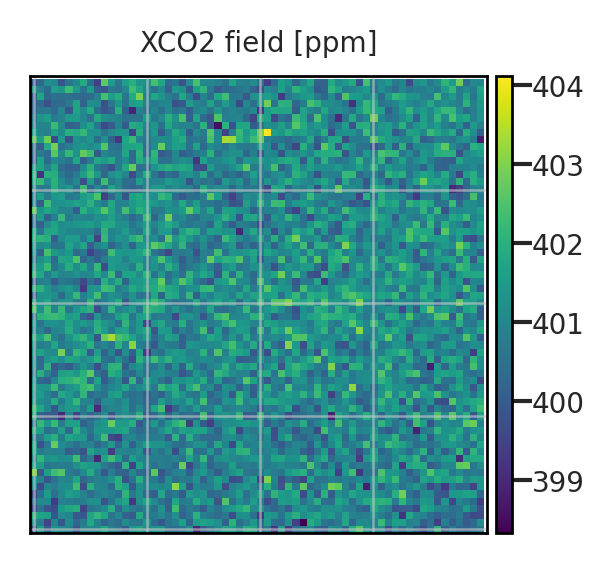

In [134]:
data = data_1
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
idx = 50
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(data.x.eval[idx, :, :, 0]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("XCO2 field [ppm]")
plt.savefig(os.path.join(dir_plots, "box_xco2_input.png"), transparent=True)

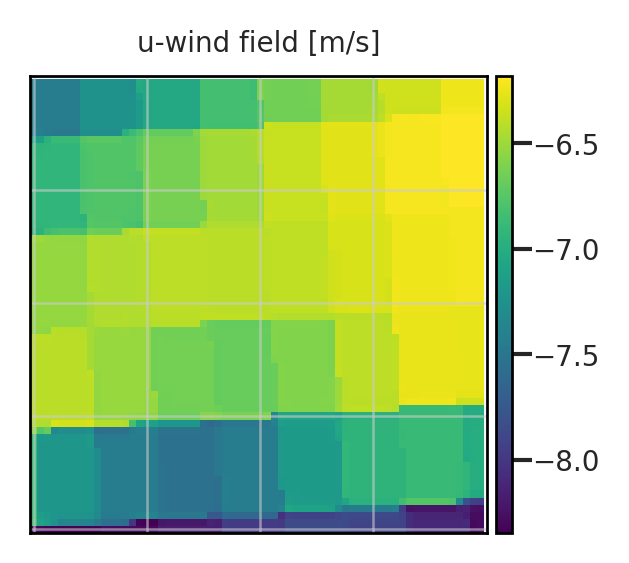

In [117]:
data = data_1
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
idx = 50
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(data.x.eval[idx, :, :, 2]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("u-wind field [m/s]")
plt.savefig(os.path.join(dir_plots, "box_wind_input.png"), transparent=True)

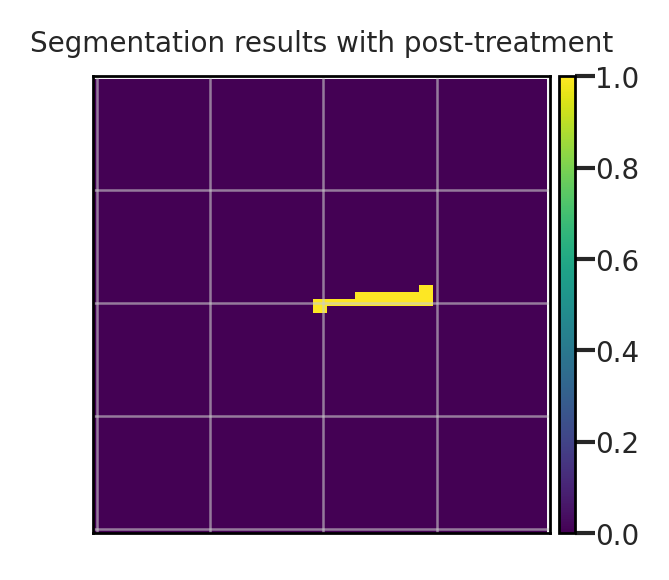

In [118]:
data = data_1
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
idx = 50
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(data.x.eval[idx, :, :, 4]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Segmentation results with post-treatment")
plt.savefig(os.path.join(dir_plots, "box_seg_input.png"), transparent=True)

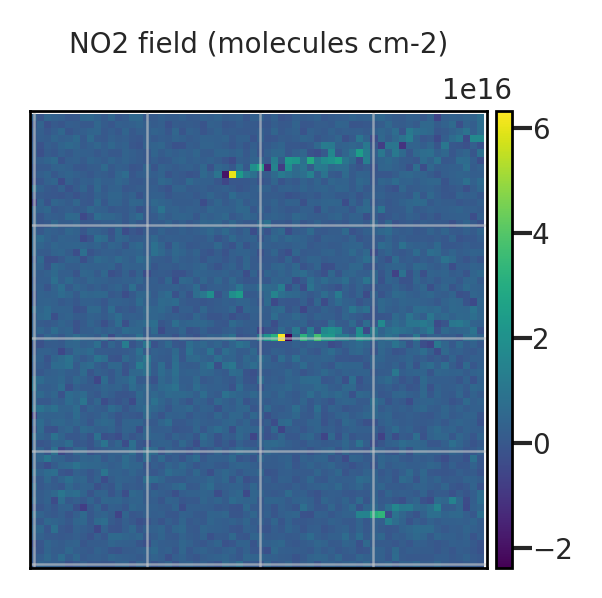

In [119]:
data = data_2
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
idx = 50
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(data.x.eval[idx, :, :, 4]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("NO2 field (molecules cm-2)")
plt.savefig(os.path.join(dir_plots, "box_no2_input.png"), transparent=True)

# Inversion: theory / Preprocessing layers

In [3]:
path_ds = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
ds = xr.open_dataset(path_ds)

In [4]:
ds

<xarray.Dataset>
Dimensions:          (idx_img: 6289, y: 64, x: 64, hour_prec: 3)
Coordinates:
  * idx_img          (idx_img) int32 0 1 2 3 4 5 ... 6284 6285 6286 6287 6288
  * y                (y) int32 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * x                (x) int32 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
Dimensions without coordinates: hour_prec
Data variables: (12/18)
    point_source     (idx_img) object ...
    time             (idx_img) datetime64[ns] ...
    xco2             (idx_img, y, x) float32 ...
    xco2_back        (idx_img, y, x) float32 ...
    xco2_alt_anthro  (idx_img, y, x) float32 ...
    no2              (idx_img, y, x) float32 ...
    ...               ...
    v                (idx_img, y, x) float32 ...
    bool_perf_seg    (idx_img, y, x) float32 ...
    w_perf_seg       (idx_img, y, x) float32 ...
    psurf            (idx_img, y, x) float32 ...
    clct             (idx_img, y, x) float32 ...
    v_hour           (idx_img) int64 ...
Attributes:
    description:  Anthropogenic XCO2 plume related data
    N_img:        6289

In [ ]:
idx = 700

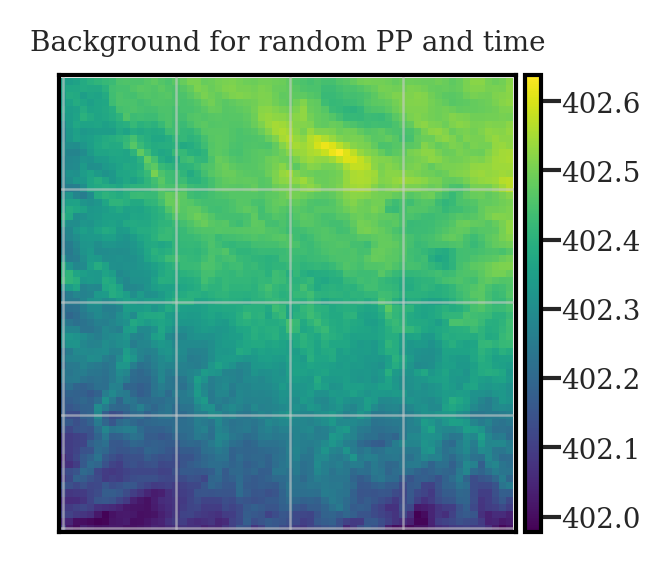

In [49]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.08,
    pad_w_ext_right=0.18,
    pad_w_int=0.2,
    pad_h_ext=0.18,
    pad_h_int=0.25,
)
Ny = int(len(ds.y))
Nx = int(len(ds.x))
i_ax = 0
ax = axs[i_ax]
data_plot = ds.xco2_back.values[idx]
im = ax.imshow(data_plot, origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
# cbar.ax.set_title("[ppmv]")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Background for random PP and time")
plt.savefig(os.path.join(dir_plots, "lip_background.png"), transparent=True)

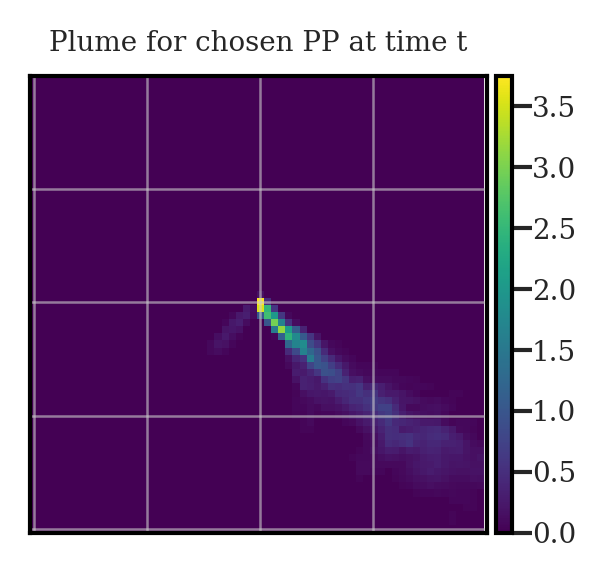

In [52]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.08,
    pad_w_ext_right=0.18,
    pad_w_int=0.2,
    pad_h_ext=0.18,
    pad_h_int=0.25,
)
Ny = int(len(ds.y))
Nx = int(len(ds.x))
i_ax = 0
ax = axs[i_ax]
data_plot = ds.plume.values[idx]
im = ax.imshow(data_plot, origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
# cbar.ax.set_title("[ppmv]")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Plume for chosen PP at time t")
plt.savefig(os.path.join(dir_plots, "lip_plume.png"), transparent=True)

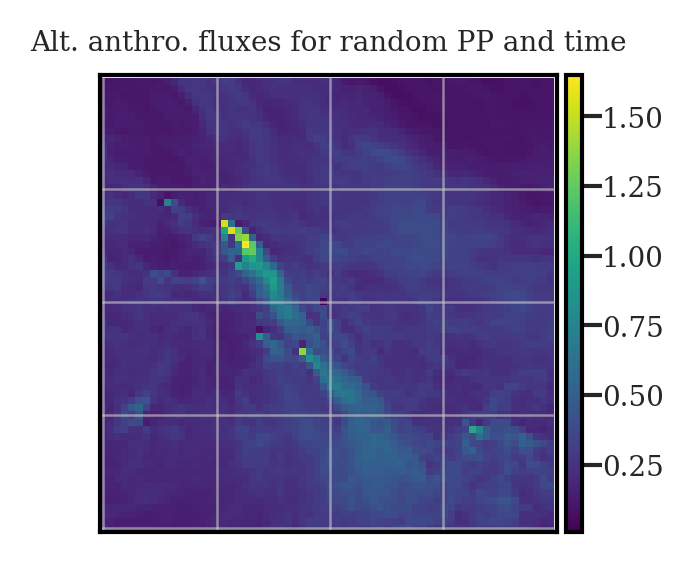

In [51]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.08,
    pad_w_ext_right=0.18,
    pad_w_int=0.2,
    pad_h_ext=0.18,
    pad_h_int=0.25,
)
Ny = int(len(ds.y))
Nx = int(len(ds.x))
i_ax = 0
ax = axs[i_ax]
data_plot = ds.xco2_alt_anthro.values[idx]
im = ax.imshow(data_plot, origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
# cbar.ax.set_title("[ppmv]")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Alt. anthro. fluxes for random PP and time")
plt.savefig(os.path.join(dir_plots, "lip_alt_anthro.png"), transparent=True)

# Lippendorf

In [10]:
path_eval_lip = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
path_valid_lip = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"

In [11]:
all_dir_lip = []
for root, dirs, files in os.walk(dir_res_lip):
    if "w_best.h5" in files:
        all_dir_lip.append(root)

### None

In [12]:
chan_3 = "None"
all_dirs_lip_none = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_none.append(dir)

In [14]:
tf.random.set_seed(10)
np.random.seed(10)
res_lip_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_none, path_eval_lip
)

197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/2
MAE 3.5839977 2.9753103
MAPE 24.262766 20.183493
197/197 [==============================] - 1s 6ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/3
MAE 3.8367445 3.2652311
MAPE 25.864473 22.340849
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/2_bis
MAE 3.6861932 3.0660553
MAPE 24.950613 20.711967
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/3_bis
MAE 3.8780556 3.2971668
MAPE 25.99184 22.521877
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/4
MAE 5.061924 4.633525
MAPE 32.824734 31.19314
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/5
MAE 4.5363307 3.9727955
MAPE 29.585331 27.234945
197/197 [=================

In [15]:
tf.random.set_seed(20)
np.random.seed(20)
res_lip_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_none, path_eval_lip
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/2
MAE 3.5839977 2.9753103
MAPE 24.262766 20.183493
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/3
MAE 3.8367445 3.2652311
MAPE 25.864473 22.340849
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/2_bis
MAE 3.6861932 3.0660553
MAPE 24.950613 20.711967
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/3_bis
MAE 3.8780556 3.2971668
MAPE 25.99184 22.521877
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/4
MAE 5.061924 4.633525
MAPE 32.824734 31.19314
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/5
MAE 4.5363307 3.9727955
MAPE 29.585331 27.234945
197/197 [=================

In [16]:
tf.random.set_seed(40)
np.random.seed(40)
res_lip_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_none, path_eval_lip
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/2
MAE 3.5839977 2.9753103
MAPE 24.262766 20.183493
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/3
MAE 3.8367445 3.2652311
MAPE 25.864473 22.340849
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/2_bis
MAE 3.6861932 3.0660553
MAPE 24.950613 20.711967
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/3_bis
MAE 3.8780556 3.2971668
MAPE 25.99184 22.521877
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/4
MAE 5.061924 4.633525
MAPE 32.824734 31.19314
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/5
MAE 4.5363307 3.9727955
MAPE 29.585331 27.234945
197/197 [=================

In [17]:
tf.random.set_seed(50)
np.random.seed(50)
res_lip_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_none, path_eval_lip
)

197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/2
MAE 3.5839977 2.9753103
MAPE 24.262766 20.183493
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/3
MAE 3.8367445 3.2652311
MAPE 25.864473 22.340849
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/2_bis
MAE 3.6861932 3.0660553
MAPE 24.950613 20.711967
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/3_bis
MAE 3.8780556 3.2971668
MAPE 25.99184 22.521877
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/4
MAE 5.061924 4.633525
MAPE 32.824734 31.19314
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/5
MAE 4.5363307 3.9727955
MAPE 29.585331 27.234945
197/197 [=================

### no2

In [7]:
chan_3 = "no2"
all_dirs_lip_no2 = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_no2.append(dir)

In [8]:
a = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_no2, path_valid_lip
)

2023-05-22 16:00:47.376320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 16:00:47.931906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14337 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-05-22 16:00:50.030339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-22 16:00:50.619436: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


144/144 [==============================] - 2s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/6
MAE 2.844011 1.8375771
MAPE 24.333832 17.792265
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/7
MAE 2.702321 1.7999451
MAPE 21.557789 17.725452
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/6_bis
MAE 2.858851 1.8628278
MAPE 24.734509 18.392918
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/10
MAE 2.90947 2.0381045
MAPE 24.013144 19.99699
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/11
MAE 2.8638856 2.0118554
MAPE 24.045183 19.467623
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/best_no2
MAE 2.8498 1.915271
MAPE 24.822823 18.241035

Ensemble
MAE 2.5608587 1.7

In [9]:
res_lip_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_no2, path_eval_lip
)

197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/6
MAE 3.4901469 2.8927221
MAPE 24.026169 19.400682
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/7
MAE 3.6166253 3.0618114
MAPE 24.013582 20.752071
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/6_bis
MAE 3.460753 2.8547287
MAPE 23.66219 19.466995
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/10
MAE 3.5485134 3.0118065
MAPE 23.529938 20.315468
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/11
MAE 3.452748 2.891615
MAPE 23.14068 19.653597
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/best_no2
MAE 3.1855035 2.6020837
MAPE 21.995306 17.529778

Ensemble
MAE 3.138808

In [10]:
res_lip_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_no2, path_eval_lip, "w_last.h5"
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/6
MAE 3.5355697 2.9129581
MAPE 24.265709 19.803366
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/7
MAE 3.654883 3.093853
MAPE 24.259901 21.208054
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/6_bis
MAE 3.5355697 2.9129581
MAPE 24.265709 19.803366
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/10
MAE 3.6338828 3.0791683
MAPE 24.08853 20.835587
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/11
MAE 3.4284477 2.8511744
MAPE 23.178083 19.474743
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/best_no2
MAE 3.266593 2.6822958
MAPE 22.575417 17.944092

Ensemble
MAE 3.18127

### seg_pred_no2

In [91]:
chan_3 = "seg_pred_no2"
all_dirs_lip_seg_pred_no2 = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_seg_pred_no2.append(dir)

In [92]:
a = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_seg_pred_no2, path_valid_lip
)

144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/0
MAE 3.426147 2.2585518
MAPE 29.32683 20.850758
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/1
MAE 3.3338656 2.065124
MAPE 25.099619 21.169828
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/1_bis
MAE 3.3338656 2.065124
MAPE 25.099619 21.169828
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/1
MAE 3.327593 2.3176947
MAPE 27.539217 23.034847
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/2
MAE 3.3379564 2.282445
MAPE 26.33146 21.950584
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/12
MAE 3.3611863 2.2511349
MAPE 27.878859 21.656677
144/144 [=========

In [93]:
res_lip_seg_pred_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_seg_pred_no2, path_eval_lip
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/0
MAE 3.8224292 3.202425
MAPE 25.544783 21.755842
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/1
MAE 4.2110386 3.7438478
MAPE 27.807451 25.583014
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/1_bis
MAE 4.2110386 3.7438478
MAPE 27.807451 25.583014
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/1
MAE 4.2862825 3.7349167
MAPE 28.136402 25.84022
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/2
MAE 4.4222336 3.9626455
MAPE 28.659117 27.18716
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/12
MAE 3.7186913 3.122326
MAPE 24.715824 21.331621
197/197 [======

### cross-sectional

In [ ]:
np.var(ds.u.values)

51.197556

In [101]:
np.var(ds.v.values)

19.222994

(array([  20.,   11.,   66.,  400., 1020., 1571., 1669., 1008.,  427.,
          97.]),
 array([-17.90995216, -14.86153889, -11.81312561,  -8.76471138,
         -5.7162981 ,  -2.66788483,   0.38052863,   3.4289422 ,
          6.47735548,   9.52576923,  12.57418251]),
 <BarContainer object of 10 artists>)

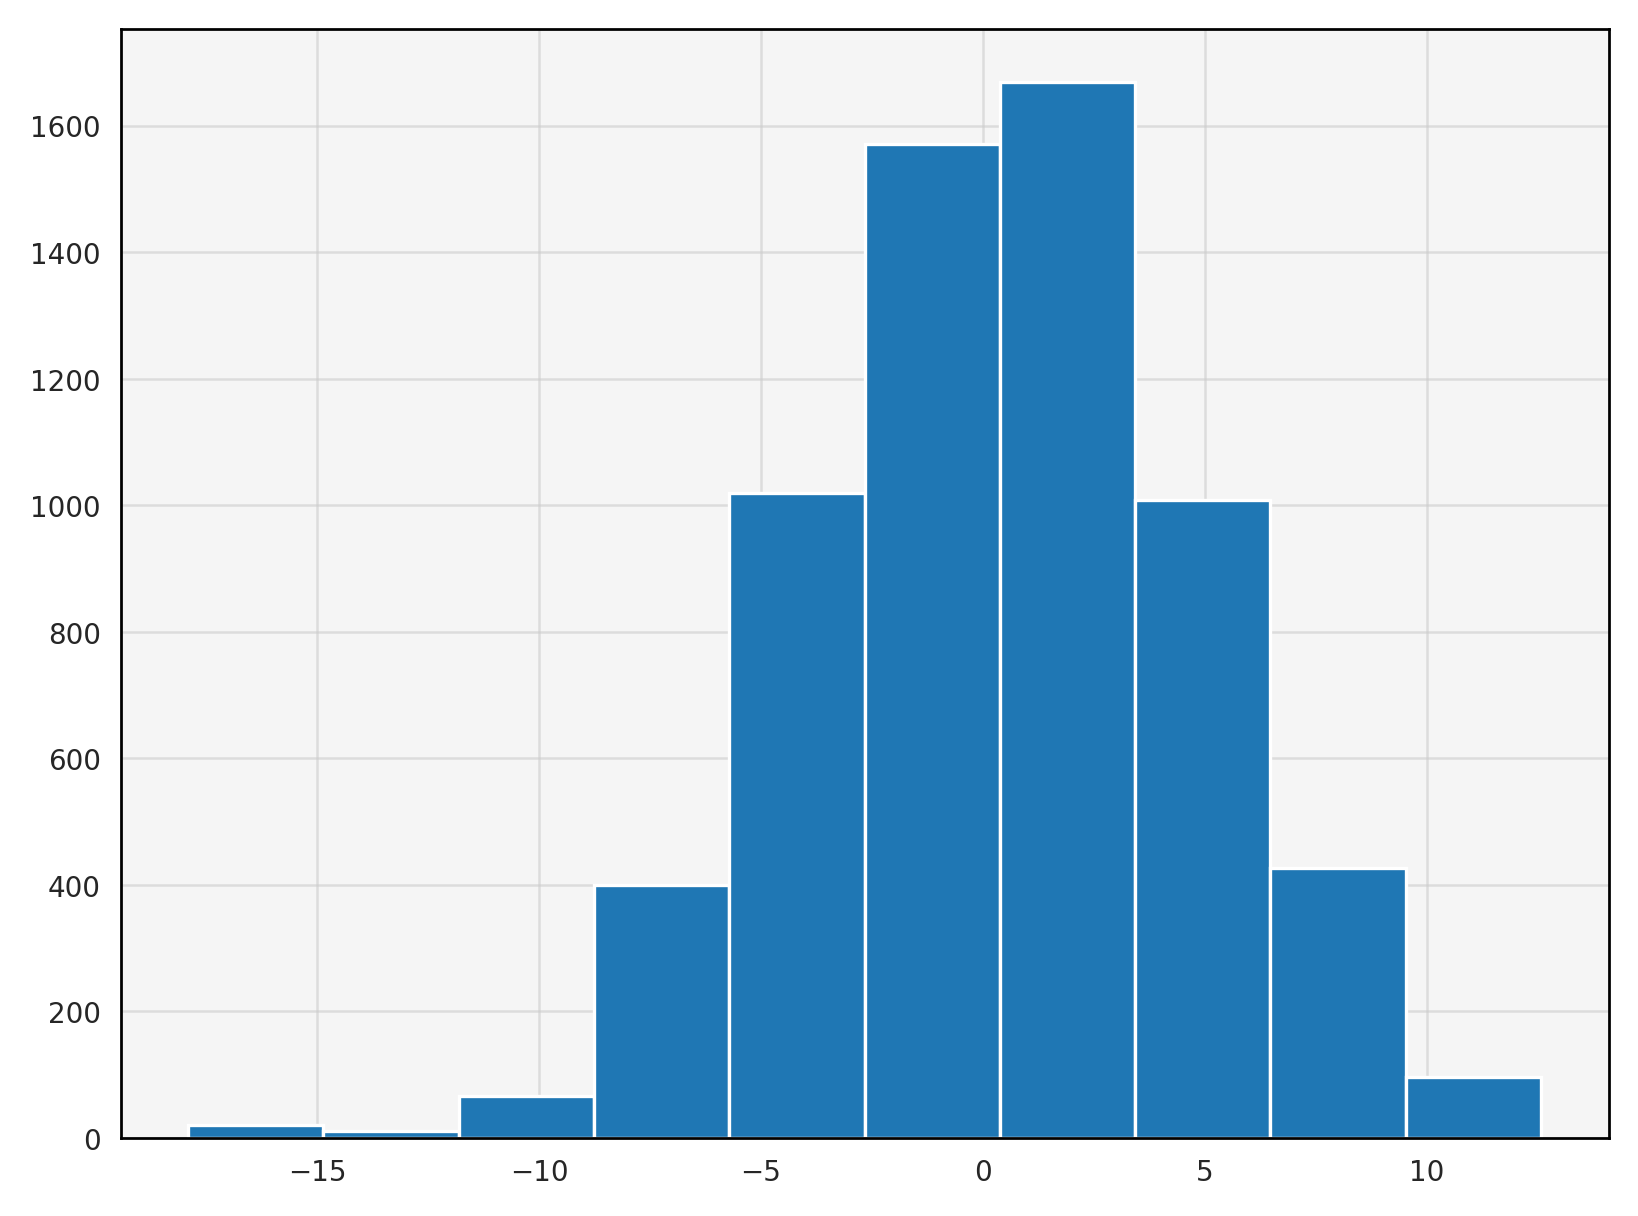

In [ ]:
plt.hist(np.mean(ds.v.values, axis=(1, 2)))

(array([ 119.,  474., 1004., 1455., 1424.,  941.,  462.,  279.,   95.,
          36.]),
 array([-12.10242367,  -7.90094805,  -3.69947195,   0.50200379,
          4.70347977,   8.90495491,  13.10643101,  17.3079071 ,
         21.50938225,  25.7108593 ,  29.91233444]),
 <BarContainer object of 10 artists>)

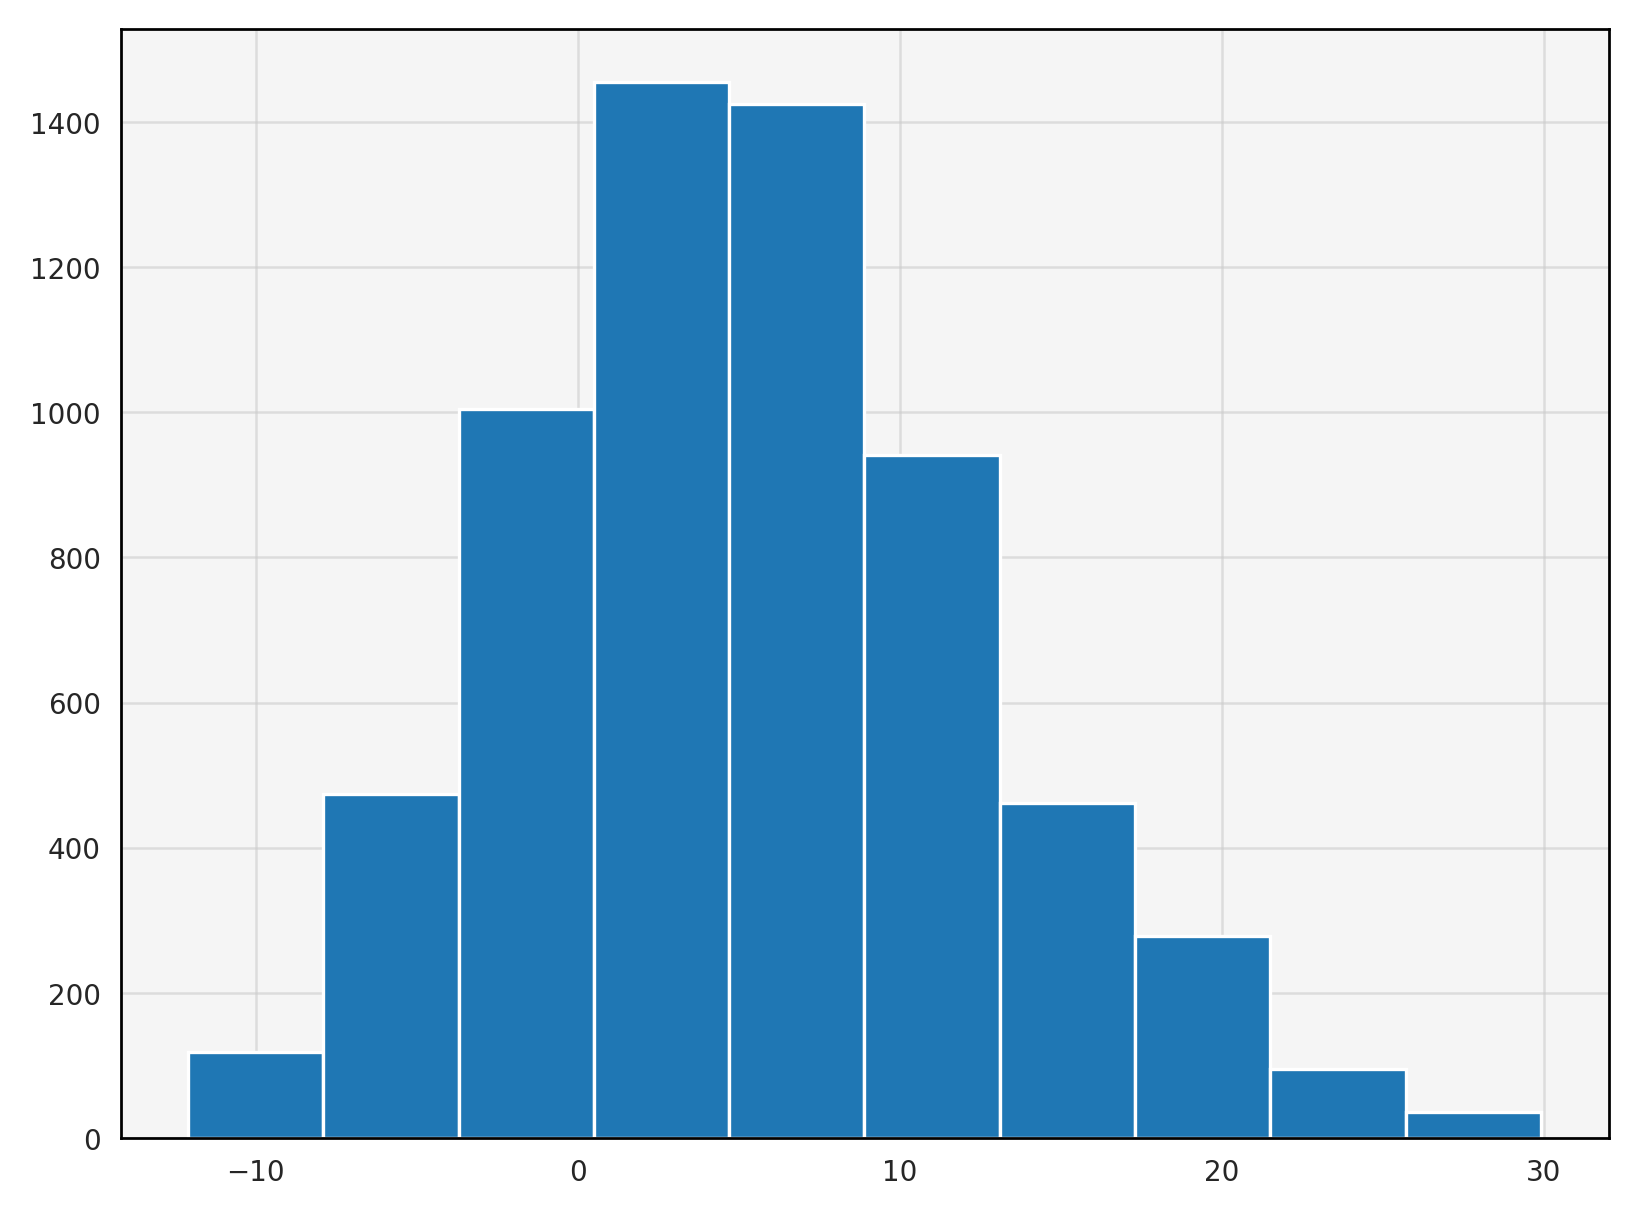

In [ ]:
plt.hist(np.mean(ds.u.values, axis=(1, 2)))

In [90]:
path_ds = os.path.join("/libre/dumontj/coco2/ddeq/eval", "2km_Lip", "cs_emiss_pred.nc")
ds = xr.open_dataset(path_ds)

In [78]:
pred = np.where(ds.cs_emiss_pred.values == -1, np.nan, ds.cs_emiss_pred.values)
idx_notnan = ~np.isnan(pred)
pred = pred[idx_notnan]
pred = np.expand_dims(pred, 1)
y = ds.emiss.values[idx_notnan, 0]
# y = np.concatenate((ds.emiss.values[0:1], ds.emiss.values[0:-1]))
y = np.expand_dims(y, 1)
print("images analysed:", np.sum(idx_notnan) / ds.attrs["N_img"])

metrics_cs = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics_cs["mae"]), np.median(metrics_cs["mae"]))
print("mape:", np.mean(metrics_cs["mape"]), np.median(metrics_cs["mape"]))
metrics_lip_cs = metrics_cs

images analysed: 0.9435522340594689
mae: 9.45554687078409 6.280673210008902
mape: 64.55498100584066 42.813141021105075


In [79]:
vec1 = metrics_cs["mape"].numpy()
vec2 = ds.v_hour.values[idx_notnan]


def group_hours(hours, num_categories):
    category_vector = []

    # Define the range size for each category
    range_size = 24 / num_categories

    # Assign category numbers to hours
    for hour in hours:
        category_index = min(
            int(hour // range_size), num_categories - 1
        )  # Ensure index does not exceed the number of categories
        category_vector.append(category_index)

    return category_vector


vec3 = category_vector = group_hours(vec2, 4)

df = pd.DataFrame({"mape": vec1, "hour": vec3})

(0.0, 200.0)

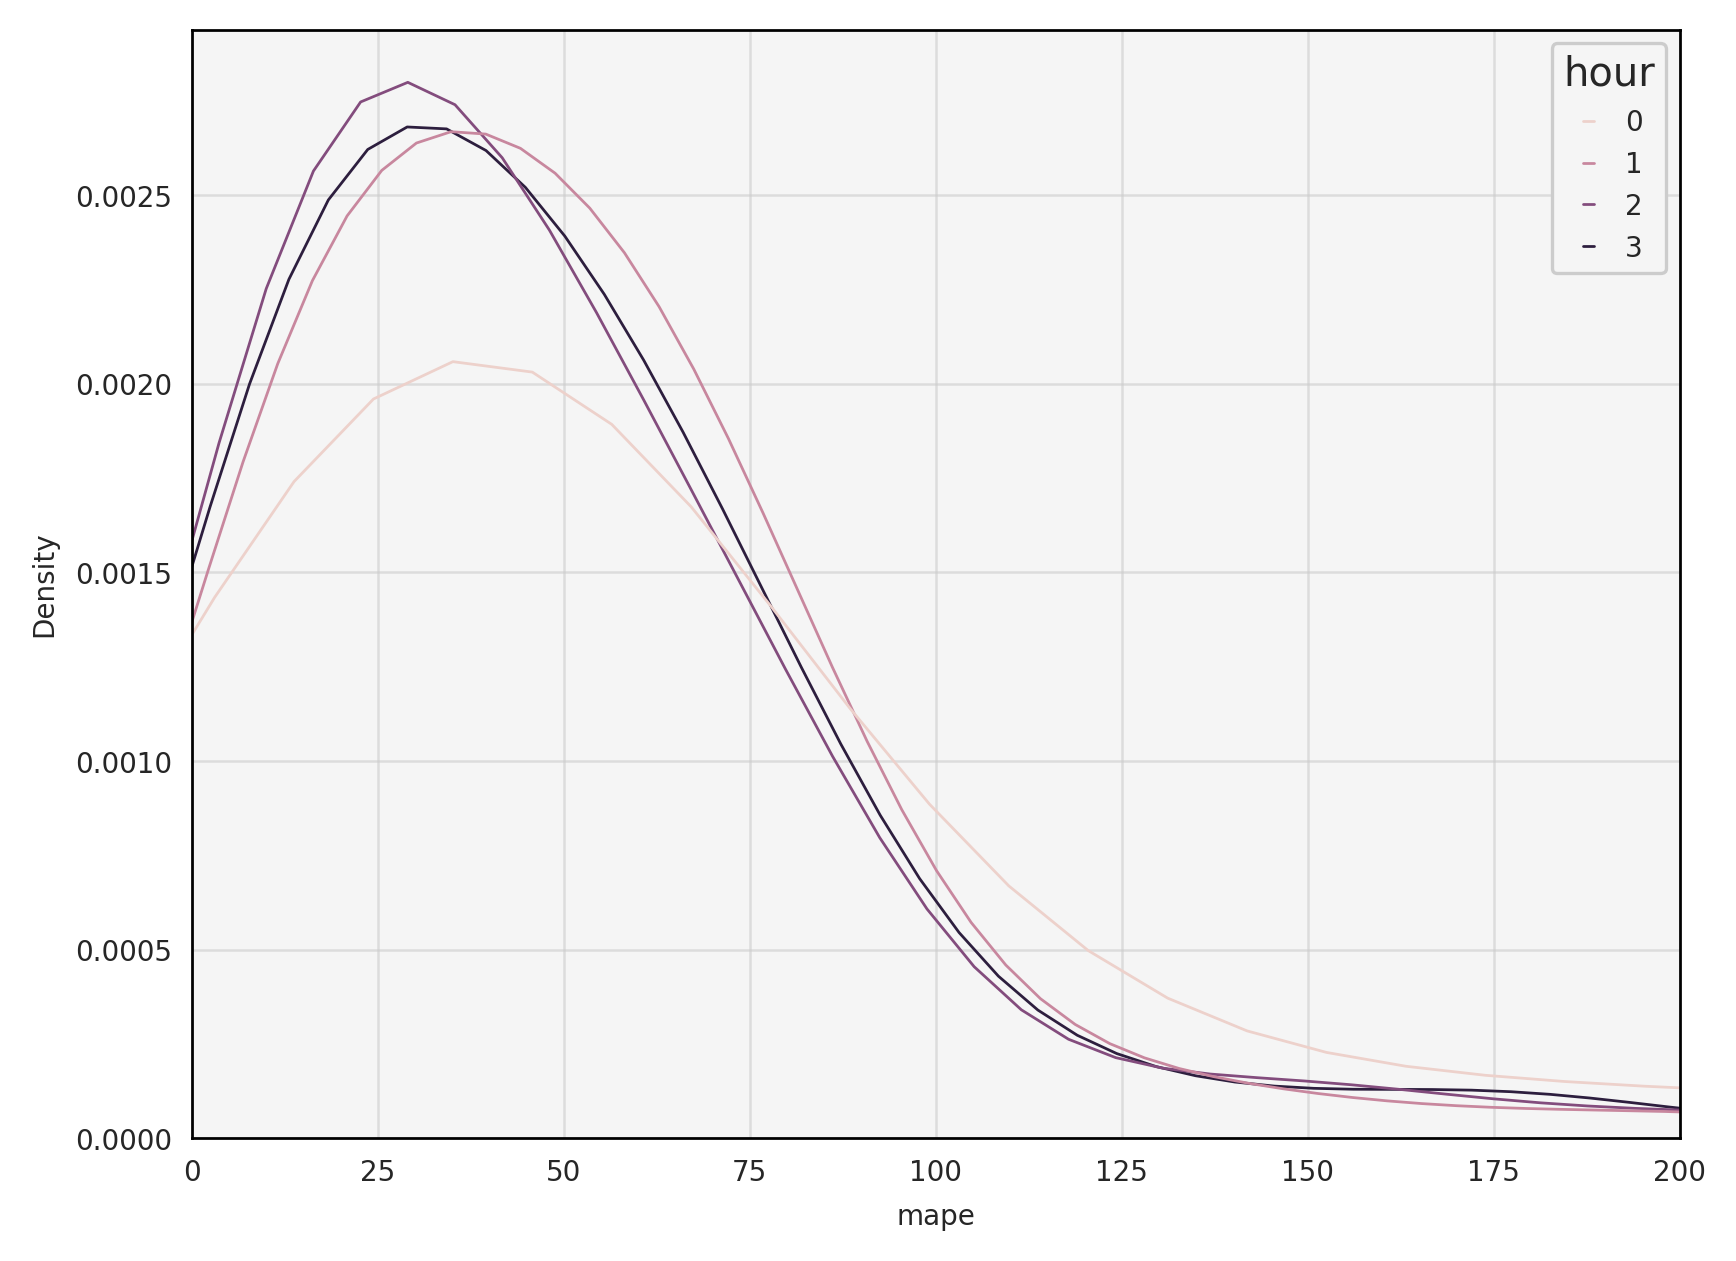

In [80]:
sns.kdeplot(df, x="mape", hue="hour")
plt.xlim(0, 200)

In [81]:
idx_day = np.where(
    (ds.v_hour.values[idx_notnan] > 10) & (ds.v_hour.values[idx_notnan] < 18),
    True,
    False,
)

idx_night = np.where(
    (ds.v_hour.values[idx_notnan] < 10) | (ds.v_hour.values[idx_notnan] > 18),
    True,
    False,
)

In [82]:
mape_day = metrics_cs["mape"][idx_day]
print("mape:", np.median(mape_day))

mape: 39.12442581143914


In [83]:
mape_night = metrics_cs["mape"][idx_night]
print("mape:", np.median(mape_night))

mape: 45.203733692385654


In [85]:
np.mean(pred - y)

1.4704421900862015

In [87]:
pred_2 = pred - np.mean(pred - y)
metrics_cs_2 = model_eval.get_inv_metrics(y, pred_2)
print("mae:", np.mean(metrics_cs_2["mae"]), np.median(metrics_cs_2["mae"]))
print("mape:", np.mean(metrics_cs_2["mape"]), np.median(metrics_cs_2["mape"]))

mae: 9.88584569058167 7.215172704884788
mape: 67.36339711695874 49.000623303836946


(array([  5.,  14.,  54., 127., 219., 355., 522., 657., 622., 656., 493.,
        393., 333., 239., 160., 165., 124.,  86.,  81.,  65.,  59.,  58.,
         52.,  43.,  43.,  23.,  19.,  24.,  23.,  18.,  14.,  11.,  16.,
         16.,  11.,  10.,   9.,   9.,   9.,   4.,   7.,   4.,  10.,   5.,
          3.,   4.,   4.,   1.,   3.,   1.,   4.,   2.,   2.,   3.,   0.,
          2.,   4.,   2.,   3.,   0.,   4.,   3.,   2.,   0.,   1.,   1.,
          2.,   1.,   1.,   2.,   2.,   0.,   2.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([-21.49261872, -19.52164996, -17.55068119, -15.57971242,
        -13.60874366, -11.63777489,  -9.66680612,  -7.69583736,
         -5.72486859,  -3.75389983,  -1.78293106,   0.18803771,
          2.15900647,   4.12997524,   6.10094401,   8.07191277,
         10.04288154,  12.0138503 ,  13.98481907,  15.95578784

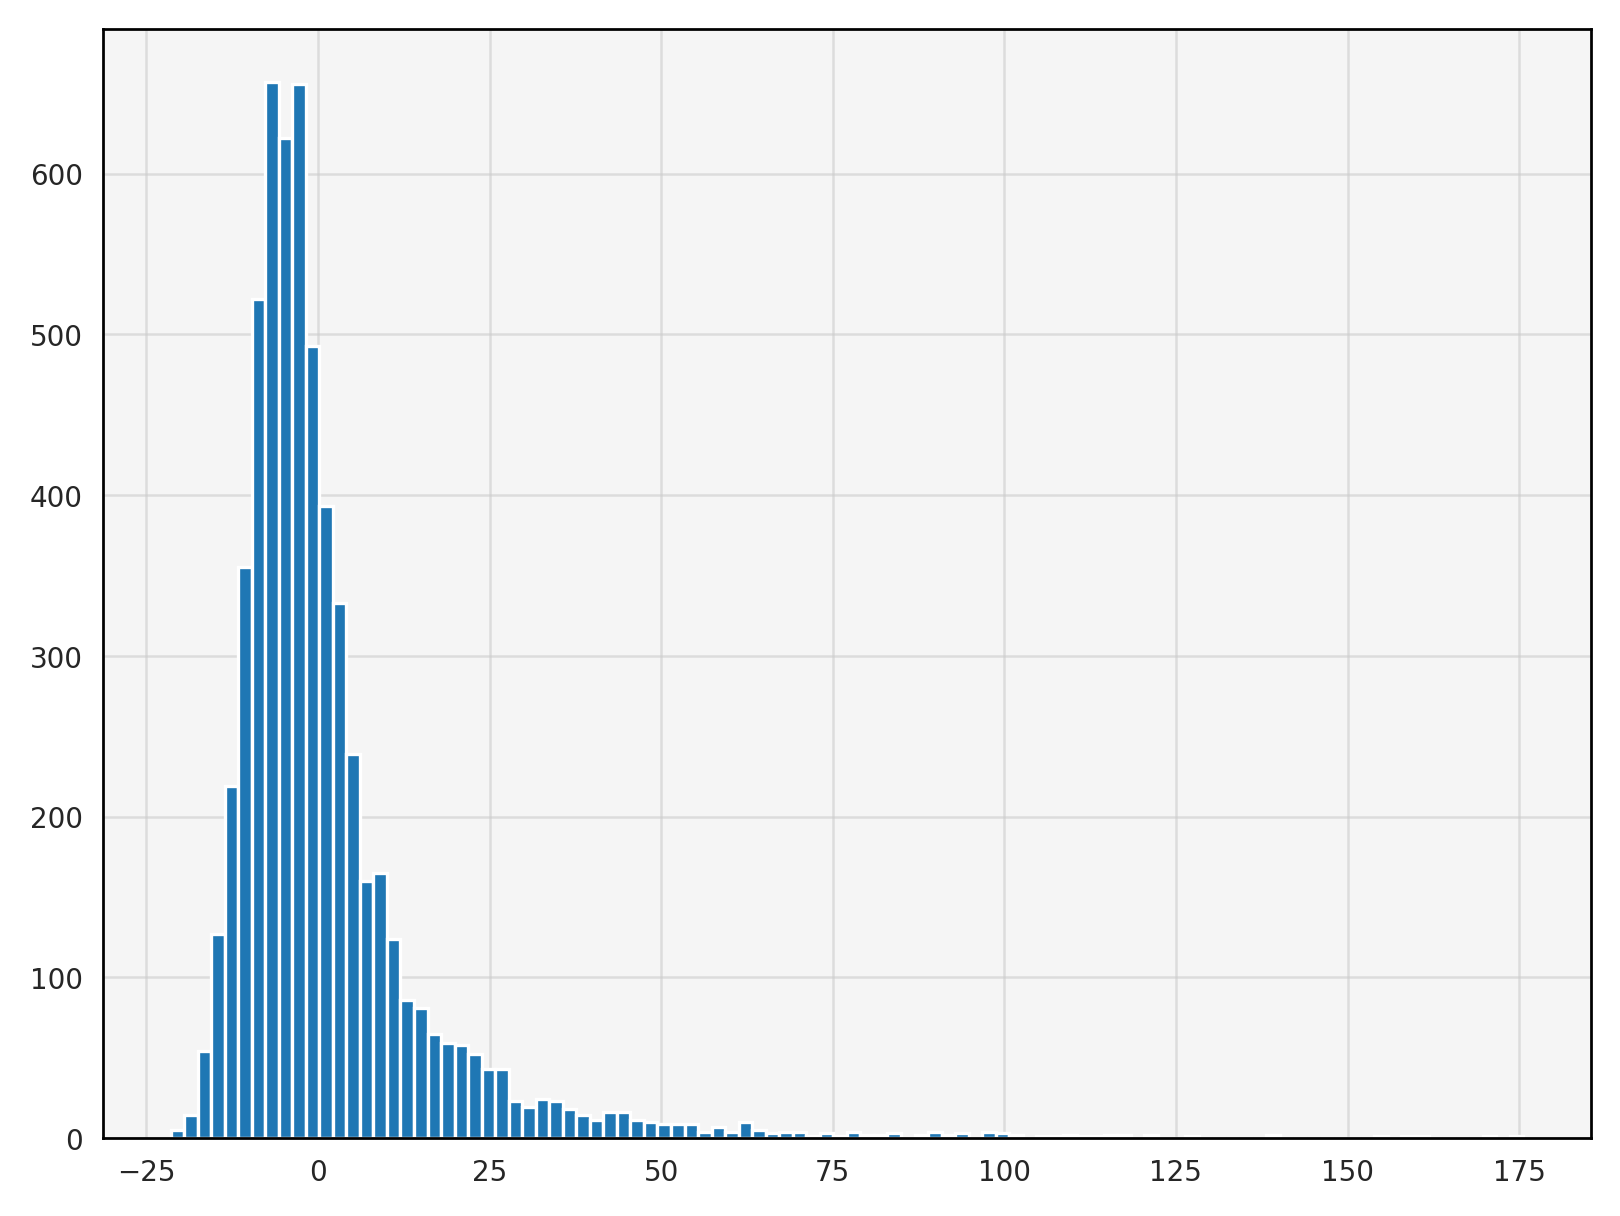

In [84]:
plt.hist(pred - y, bins=100)

## Performance histograms

In [149]:
metrics_none = res_lip_none["metrics"]
metrics_seg_pred_no2 = res_lip_seg_pred_no2["metrics"]
metrics_no2 = res_lip_no2["metrics"]
metrics_cs = metrics_lip_cs

In [154]:
all_df = model_eval.build_df_perf_inv(
    {
        "none": metrics_none,
        "seg_pred_no2": metrics_seg_pred_no2,
        "no2": metrics_no2,
        "cs": metrics_cs,
    }
)
result = all_df["res"]
df_mae = all_df["df_mae"]
df_mape = all_df["df_mape"]

result_latex = result.rename(columns={result.iloc[:, 0].name[0]: "APE"})
result_latex = result_latex.rename(columns={result.iloc[:, 4].name[0]: "AE"})
result_latex.insert(3, "", "")

In [155]:
print(result_latex.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{APE} & \multicolumn{3}{l}{AE} \\
{} &  25\% &  50\% &  75\% & 25\% & 50\% & 75\% \\
Add. input:            &      &      &      &     &     &     \\
\midrule
No additional input    &  9.7 & 21.1 & 35.5 & 1.4 & 3.1 & 5.1 \\
Segmentation           & 11.1 & 23.1 & 36.4 & 1.6 & 3.3 & 5.5 \\
NO2                    &  8.2 & 17.8 & 30.1 & 1.2 & 2.6 & 4.5 \\
Cross-sectional method & 20.6 & 40.5 & 64.5 & 2.9 & 5.9 & 9.5 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3994034/1320843946.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_latex.to_latex())


paper-inv/lip_perf.pdf


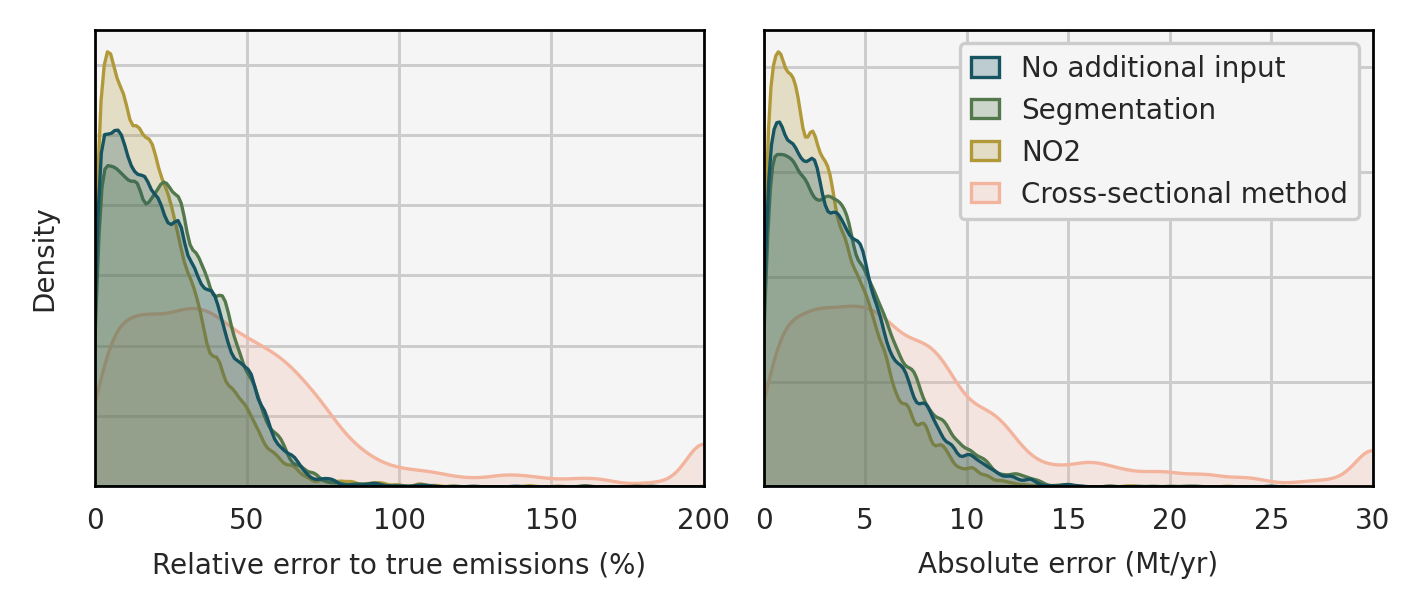

In [166]:
mympf.setMatplotlibParam()
axs = mympf.set_figure_axs(
    1,
    2,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

i_ax = 0
sns.kdeplot(
    df_mape,
    x="Relative error to true emissions (%)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 200)

i_ax = 1
sns.kdeplot(
    df_mae,
    x="Absolute error (Mt/yr)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 30)

for ax in axs:
    ax.grid(linewidth=0.7, alpha=1)
    ax.set_yticklabels([])
for ax in [axs[0]]:
    ax.get_legend().remove()
for ax in [axs[1]]:
    ax.legend_.set_title(None)
    ax.set_ylabel("")

name_fig = os.path.join(dir_plots, f"lip_perf.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

<AxesSubplot: ylabel='Density'>

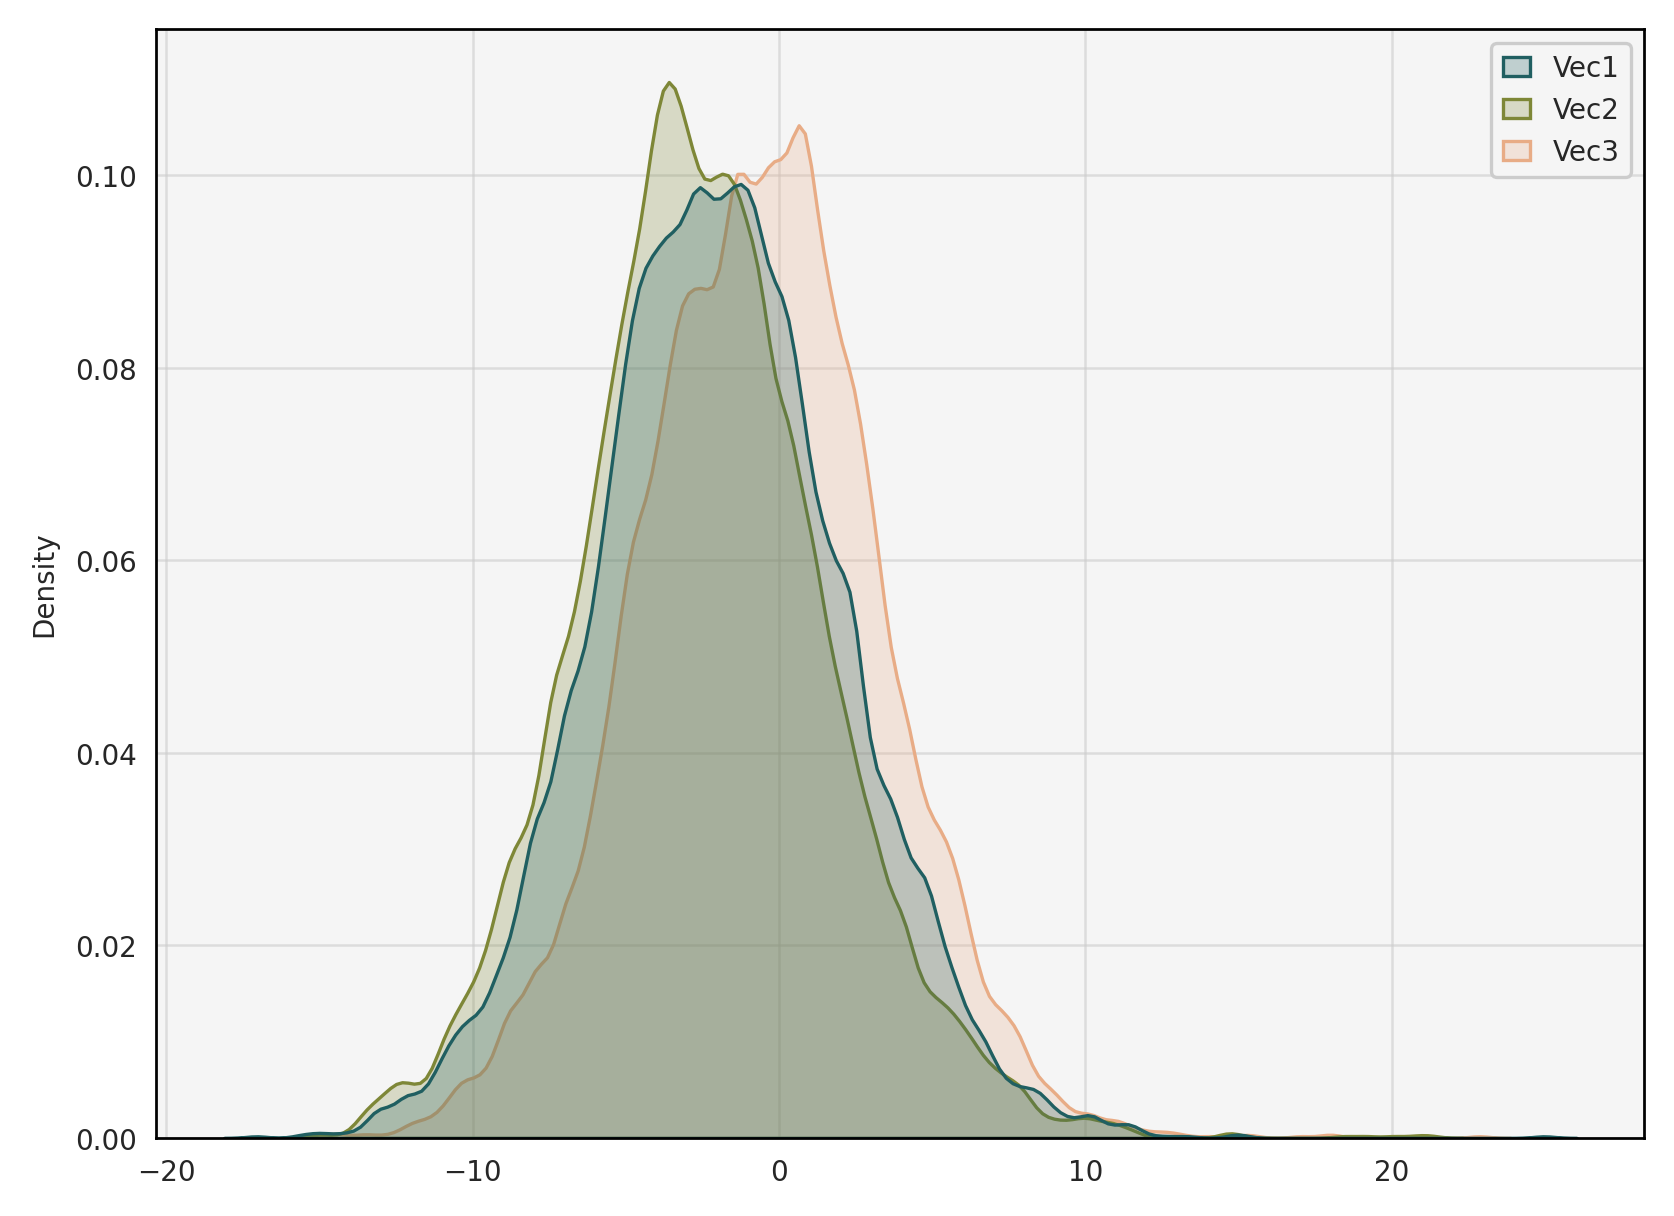

In [144]:
vec1 = np.squeeze(res_lip_none["pred"]) - np.squeeze(res_lip_none["data"].y.eval)
vec2 = np.squeeze(res_lip_seg_pred_no2["pred"]) - np.squeeze(
    res_lip_seg_pred_no2["data"].y.eval
)
vec3 = np.squeeze(res_lip_no2["pred"]) - np.squeeze(res_lip_no2["data"].y.eval)

df = pd.DataFrame({"Vec1": vec1, "Vec2": vec2, "Vec3": vec3})

sns.kdeplot(
    df,
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)

# Boxberg

In [4]:
path_eval_box = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
path_valid_box = "/libre/dumontj/coco2/dl-input/2km_forBox_2/valid_dataset.nc"
dir_res_box = os.path.join(dir_res, "box")

In [5]:
all_dir_box = []
for root, dirs, files in os.walk(dir_res_box):
    if "w_best.h5" in files:
        all_dir_box.append(root)

### None

In [56]:
chan_3 = "None"

In [57]:
all_dirs_box_none = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_none.append(dir)

In [58]:
a = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_none, path_valid_box
)

144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/best_none
MAE 4.041154 2.5874119
MAPE 31.871805 27.150791
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/0
MAE 4.147315 2.5250351
MAPE 30.96323 26.378925
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/1
MAE 4.1564775 2.5150614
MAPE 31.388187 26.472446
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/2
MAE 4.162638 2.4470153
MAPE 30.744167 26.366669
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/3
MAE 4.374683 2.5641139
MAPE 31.702213 27.7458

Ensemble
MAE 3.9770863 2.367831
MAPE 29.637547 25.618237


In [59]:
res_box_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_none, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/best_none
MAE 4.679584 4.0662556
MAPE 24.797361 22.490479
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/0
MAE 5.0548897 4.4549465
MAPE 26.573517 24.365309
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/1
MAE 5.141094 4.5923405
MAPE 26.978266 24.825155
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/2
MAE 5.333197 4.782651
MAPE 28.003769 25.994995
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/3
MAE 5.4686666 4.918874
MAPE 28.989326 26.51363

Ensemble
MAE 4.9516516 4.4090395
MAPE 26.048527 23.982283


### no2

In [50]:
chan_3 = "no2"
all_dirs_box_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_no2.append(dir)

In [51]:
a = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_no2, path_valid_box
)

144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/best_no2
MAE 2.8605237 1.9971411
MAPE 24.375406 20.227646
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/5
MAE 2.8905134 1.9667952
MAPE 24.004147 19.751545
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/6
MAE 3.003226 2.0452814
MAPE 24.43713 20.913666
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/7
MAE 2.9383335 2.0402303
MAPE 24.9945 20.065708
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/8
MAE 2.9216385 2.0280993
MAPE 24.009941 20.137493

Ensemble
MAE 2.7822301 1.8922849
MAPE 23.185358 19.0223


In [52]:
res_box_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_no2, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/best_no2
MAE 5.940708 5.7449207
MAPE 30.630848 31.033157
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/5
MAE 6.864032 6.692423
MAPE 35.20676 36.39846
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/6
MAE 6.597976 6.4883623
MAPE 33.889805 35.139126
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/7
MAE 7.089327 7.020133
MAPE 36.43763 37.932426
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/8
MAE 8.507347 8.454634
MAPE 43.891212 45.54227

Ensemble
MAE 6.9351788 6.8675127
MAPE 35.614475 36.93396


### seg_pred_no2

In [61]:
chan_3 = "seg_pred_no2"
all_dirs_box_seg_pred_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_seg_pred_no2.append(dir)

In [62]:
a = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_seg_pred_no2, path_valid_box
)

144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/best_seg_pred_no2
MAE 3.2492578 2.1794708
MAPE 26.669922 22.618473
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/11
MAE 3.5664852 2.257013
MAPE 26.930904 24.008644
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/12
MAE 3.5101075 2.2322204
MAPE 26.843927 23.113708

Ensemble
MAE 3.2154384 2.0748158
MAPE 24.950117 21.750433


In [63]:
res_box_seg_pred_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_seg_pred_no2, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/best_seg_pred_no2
MAE 6.434844 6.334133
MAPE 33.554993 34.088192
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/11
MAE 7.240037 7.2482715
MAPE 37.730835 39.139442
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/12
MAE 7.2844315 7.1733494
MAPE 37.787827 39.168636

Ensemble
MAE 6.919018 6.847526
MAPE 35.96443 36.98802


### cross-sectional

In [53]:
path_ds = os.path.join("/libre/dumontj/coco2/ddeq/eval", "2km_Box", "cs_emiss_pred.nc")
ds = xr.open_dataset(path_ds)

In [54]:
pred = np.where(ds.cs_emiss_pred.values == -1, np.nan, ds.cs_emiss_pred.values)
idx_notnan = ~np.isnan(pred)
pred = pred[idx_notnan]
pred = np.expand_dims(pred, 1)
y = ds.emiss.values[idx_notnan, 0]
y = np.expand_dims(y, 1)
print("images analysed:", np.sum(idx_notnan) / ds.attrs["N_img"])

metrics_cs = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics_cs["mae"]), np.median(metrics_cs["mae"]))
print("mape:", np.mean(metrics_cs["mape"]), np.median(metrics_cs["mape"]))

metrics_box_cs = metrics_cs

images analysed: 0.8495786293528383
mae: 9.727348490085312 7.730007449884406
mape: 52.86260729526279 41.52475536655409


## Performance histograms

In [271]:
metrics_none = res_box_none["metrics"]
metrics_no2 = res_box_no2["metrics"]
metrics_seg_pred_no2 = res_box_seg_pred_no2["metrics"]
metrics_cs = metrics_box_cs

In [320]:
all_df = model_eval.build_df_perf_inv(
    {
        "none": metrics_none,
        "seg_pred_no2": metrics_seg_pred_no2,
        "no2": metrics_no2,
        "cs": metrics_cs,
    }
)
result = all_df["res"]
df_mae = all_df["df_mae"]
df_mape = all_df["df_mape"]
result_latex = result.rename(columns={result.iloc[:, 0].name[0]: "APE"})
result_latex = result_latex.rename(columns={result.iloc[:, 4].name[0]: "AE"})
result_latex.insert(3, "", "")

In [321]:
print(result_latex.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{APE} & \multicolumn{3}{l}{AE} \\
{} &  25\% &  50\% &  75\% & 25\% & 50\% &  75\% \\
Add. input:            &      &      &      &     &     &      \\
\midrule
No additional input    & 12.1 & 24.0 & 37.4 & 2.2 & 4.4 &  7.1 \\
Segmentation           & 24.4 & 37.0 & 48.4 & 4.3 & 6.8 &  9.3 \\
NO2                    & 26.2 & 36.9 & 45.7 & 4.5 & 6.9 &  9.3 \\
Cross-sectional method & 22.1 & 41.5 & 61.6 & 4.0 & 7.7 & 11.6 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3908447/1320843946.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_latex.to_latex())


paper-inv/box_perf.pdf


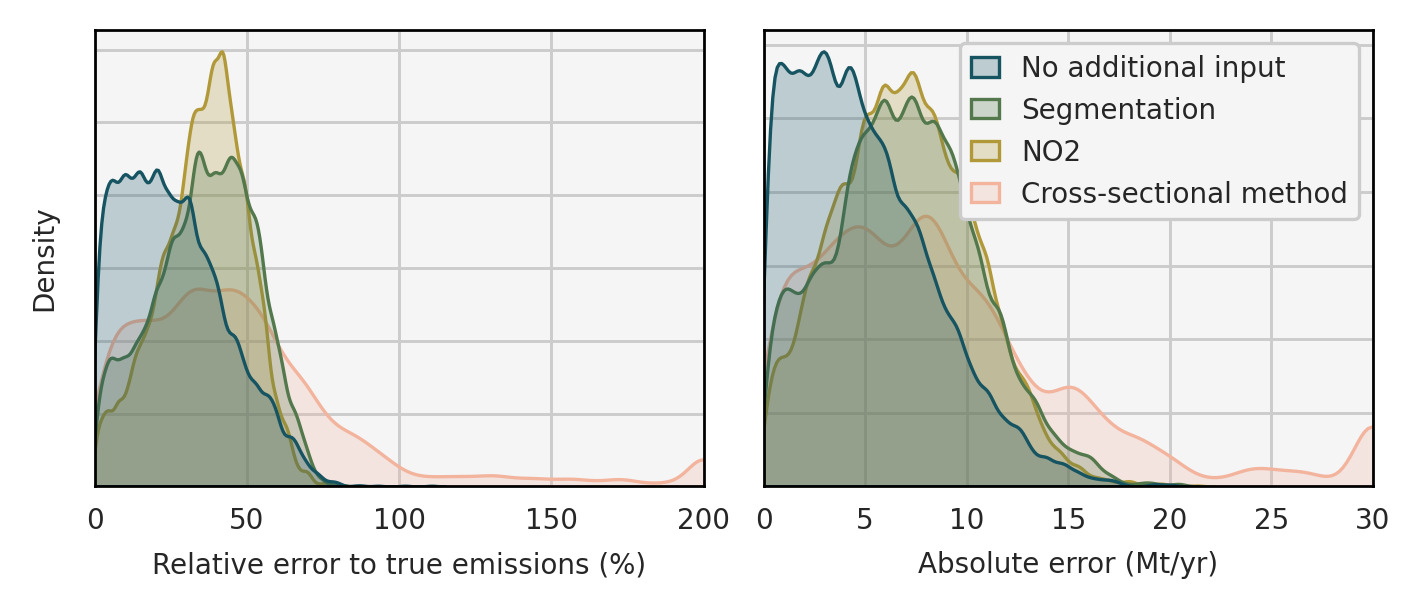

In [326]:
mympf.setMatplotlibParam()
axs = mympf.set_figure_axs(
    1,
    2,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

i_ax = 0
sns.kdeplot(
    df_mape,
    x="Relative error to true emissions (%)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 200)

i_ax = 1
sns.kdeplot(
    df_mae,
    x="Absolute error (Mt/yr)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 30)

for ax in axs:
    ax.grid(linewidth=0.7, alpha=1)
    ax.set_yticklabels([])
for ax in [axs[0]]:
    ax.get_legend().remove()
for ax in [axs[1]]:
    ax.legend_.set_title(None)
    ax.set_ylabel("")

name_fig = os.path.join(dir_plots, f"box_perf.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

### Residuals

In [65]:
vec1 = np.squeeze(res_box_none["pred"]) - np.squeeze(res_box_none["data"].y.eval)
vec2 = np.squeeze(res_box_seg_pred_no2["pred"]) - np.squeeze(
    res_box_seg_pred_no2["data"].y.eval
)
vec3 = np.squeeze(res_box_no2["pred"]) - np.squeeze(res_box_no2["data"].y.eval)

df = pd.DataFrame({"No additional input": vec1, "Segmentation": vec2, "NO2": vec3})

paper-inv/box_residuals.pdf


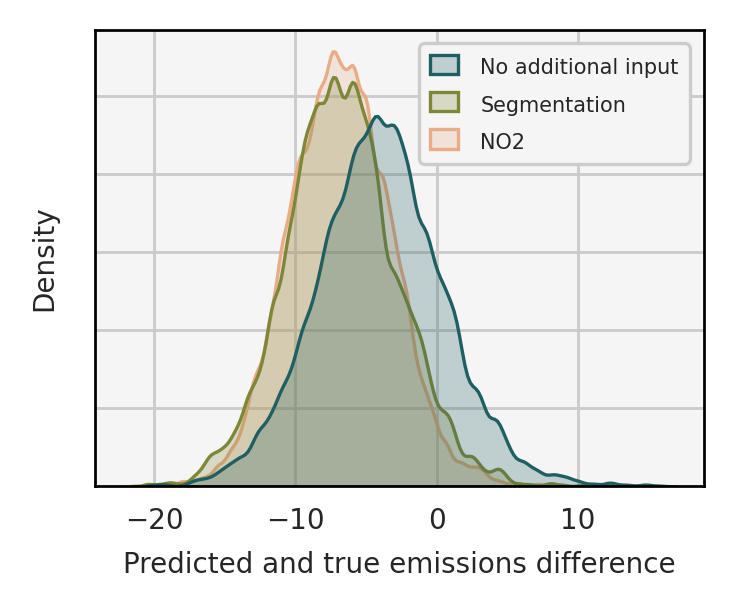

In [75]:
mympf.setMatplotlibParam()
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)


sns.kdeplot(
    df,
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[0],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)

plt.xlabel("Predicted and true emissions difference")
axs[0].set_yticklabels([])
axs[0].grid(linewidth=0.7, alpha=1)
legend = plt.gca().get_legend()
for text in legend.texts:
    text.set_fontsize(5)

name_fig = os.path.join(dir_plots, f"box_residuals.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

### no2+plume_scaling

In [7]:
dir_res_exp_scaling = (
    "/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34"
)
all_dir_box_scaling = []
for root, dirs, files in os.walk(dir_res_exp_scaling):
    if "w_best.h5" in files:
        all_dir_box_scaling.append(root)

In [8]:
chan_3 = "no2"
all_dirs_box_no2 = []
for dir in all_dir_box_scaling:
    cfg = OmegaConf.load(os.path.join(dir_res_exp_scaling, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_no2.append(dir)

In [10]:
res_box_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_no2, path_eval_box
)

197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/6
MAE 7.3465433 7.2403917
MAPE 37.619568 39.136017
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/7
MAE 6.821181 6.7289143
MAPE 35.16927 36.854523
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/8
MAE 6.705566 6.605998
MAPE 34.4618 35.63858
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/9
MAE 6.609876 6.4496
MAPE 33.949524 35.02828
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/10
MAE 5.054753 4.573079
MAPE 26.059977 24.872438
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/11
MAE 5.8548794 5.6

### seg_pred_no2+plume_scaling

In [11]:
chan_3 = "seg_pred_no2"
all_dirs_box_seg_pred_no2 = []
for dir in all_dir_box_scaling:
    cfg = OmegaConf.load(os.path.join(dir_res_exp_scaling, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_seg_pred_no2.append(dir)

In [13]:
res_box_seg_pred_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_seg_pred_no2, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/12
MAE 6.183932 5.9629297
MAPE 32.495316 32.08219
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/13
MAE 6.3988605 6.246668
MAPE 33.706463 34.02571
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/14
MAE 5.669814 5.383507
MAPE 29.847765 29.062506
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/15
MAE 6.343624 6.2053995
MAPE 33.39884 33.521297
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/16
MAE 5.178926 4.655861
MAPE 27.615128 25.010065
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/17
MAE 5.346

# Turow

In [3]:
path_eval_tur = "/libre/dumontj/coco2/dl-input/2km_Tur/train_dataset.nc"
path_valid_tur = "/libre/dumontj/coco2/dl-input/2km_forTur_2/valid_dataset.nc"
dir_res_tur = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur"

In [4]:
all_dir_tur = []
for root, dirs, files in os.walk(dir_res_tur):
    if "w_best.h5" in files:
        all_dir_tur.append(root)

### None

In [5]:
chan_3 = "None"
all_dirs_tur_none = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_none.append(dir)

In [6]:
a = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_tur_none, path_valid_tur
)

2023-05-15 17:15:06.083849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 17:15:06.617504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14349 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-05-15 17:15:08.343377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-15 17:15:08.922170: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


144/144 [==============================] - 2s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/5
MAE 4.067082 2.6052423
MAPE 29.77137 24.876785
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/6
MAE 4.1182313 2.6661286
MAPE 30.247755 25.234287
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/7
MAE 4.10341 2.6245542
MAPE 29.752699 25.238457
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/8
MAE 4.1916213 2.7555919
MAPE 30.636671 26.198505
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_none
MAE 4.3346696 2.646425
MAPE 30.085022 25.005621

Ensemble
MAE 4.0022736 2.526895
MAPE 28.77304 24.095009


In [7]:
res_tur_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_tur_none, path_eval_tur
)

197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/5
MAE 2.9996278 2.3580718
MAPE 35.782074 28.137375
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/6
MAE 2.998567 2.455308
MAPE 35.68916 29.156202
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/7
MAE 2.7834115 2.2632074
MAPE 33.09786 26.938519
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/8
MAE 2.856231 2.3425508
MAPE 33.935307 27.606129
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_none
MAE 2.6698227 2.1982093
MAPE 31.480198 25.849072

Ensemble
MAE 2.7308133 2.2194538
MAPE 32.51374 26.350822


### no2

In [8]:
chan_3 = "no2"
all_dirs_tur_no2 = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_no2.append(dir)

In [9]:
a = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_tur_no2, path_valid_tur
)

144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/16
MAE 2.977351 2.1108468
MAPE 23.607754 18.974384
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/17
MAE 3.0661805 2.1110566
MAPE 24.124739 19.504812
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/18
MAE 2.957907 2.0414796
MAPE 23.546875 18.600176
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/19
MAE 3.0222545 2.0664492
MAPE 23.567602 18.693897
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_no2
MAE 3.067396 2.1005766
MAPE 23.542376 19.207233

Ensemble
MAE 2.8567276 1.9658847
MAPE 22.459383 17.799608


In [10]:
res_tur_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_tur_no2, path_eval_tur
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/16
MAE 2.4300156 1.976253
MAPE 28.839323 23.603523
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/17
MAE 2.5073469 2.0251865
MAPE 29.798145 23.77751
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/18
MAE 2.4483113 1.9639859
MAPE 29.049381 23.36801
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/19
MAE 2.4597325 2.0031176
MAPE 29.11802 23.762636
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_no2
MAE 2.323162 1.8594131
MAPE 27.281223 22.364548

Ensemble
MAE 2.332573 1.8805408
MAPE 27.671862 22.215904


### seg_pred_no2

In [11]:
chan_3 = "seg_pred_no2"
all_dirs_tur_seg_pred_no2 = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_seg_pred_no2.append(dir)

In [12]:
a = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_tur_seg_pred_no2, path_valid_tur
)

144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/1
MAE 3.4932976 2.4141335
MAPE 26.18005 22.456104
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/2
MAE 3.499834 2.4719086
MAPE 26.876158 22.395021
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/3
MAE 3.260008 2.2729826
MAPE 25.544613 20.444235
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/4
MAE 3.4345517 2.3617506
MAPE 26.430733 22.039463
144/144 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_seg_pred_no2
MAE 3.5997365 2.2621372
MAPE 25.531698 21.66985

Ensemble
MAE 3.186628 2.2063367
MAPE 23.91555 20.031368


In [13]:
res_tur_seg_pred_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_tur_seg_pred_no2, path_eval_tur
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/1
MAE 2.9019916 2.356587
MAPE 34.175102 27.884895
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/2
MAE 2.7402403 2.2133832
MAPE 32.5219 26.20091
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/3
MAE 3.077881 2.459166
MAPE 37.34555 28.563457
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/4
MAE 2.807654 2.2129903
MAPE 33.45622 26.256775
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_seg_pred_no2
MAE 2.5919542 2.0535808
MAPE 31.11224 23.80721

Ensemble
MAE 2.6103942 2.1036615
MAPE 31.227133 24.352915


### cross-sectional

In [14]:
path_ds = os.path.join("/libre/dumontj/coco2/ddeq/eval", "2km_Tur", "cs_emiss_pred.nc")
ds = xr.open_dataset(path_ds)

In [15]:
pred = np.where(ds.cs_emiss_pred.values == -1, np.nan, ds.cs_emiss_pred.values)
idx_notnan = ~np.isnan(pred)
pred = pred[idx_notnan]
pred = np.expand_dims(pred, 1)
y = ds.emiss.values[idx_notnan, 0]
y = np.expand_dims(y, 1)
print("images analysed:", np.sum(idx_notnan) / ds.attrs["N_img"])

metrics_cs = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics_cs["mae"]), np.median(metrics_cs["mae"]))
print("mape:", np.mean(metrics_cs["mape"]), np.median(metrics_cs["mape"]))

metrics_tur_cs = metrics_cs

images analysed: 0.9949117506757831
mae: 8.17825064643822 4.471558506868509
mape: 97.83589002098984 52.12086537159644


## Performance histograms

In [16]:
metrics_none = res_tur_none["metrics"]
metrics_seg_pred_no2 = res_tur_seg_pred_no2["metrics"]
metrics_no2 = res_tur_no2["metrics"]
metrics_cs = metrics_tur_cs

In [17]:
all_df = model_eval.build_df_perf_inv(
    {
        "none": metrics_none,
        "seg_pred_no2": metrics_seg_pred_no2,
        "no2": metrics_no2,
        "cs": metrics_cs,
    }
)
result = all_df["res"]
df_mae = all_df["df_mae"]
df_mape = all_df["df_mape"]
result_latex = result.rename(columns={result.iloc[:, 0].name[0]: "APE"})
result_latex = result_latex.rename(columns={result.iloc[:, 4].name[0]: "AE"})
result_latex.insert(3, "", "")

In [18]:
print(result_latex.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{APE} & \multicolumn{3}{l}{AE} \\
{} &  25\% &  50\% &  75\% & 25\% & 50\% & 75\% \\
Add. input:            &      &      &      &     &     &     \\
\midrule
No additional input    & 12.7 & 26.4 & 43.8 & 1.1 & 2.2 & 3.8 \\
Segmentation           & 11.6 & 24.4 & 42.6 & 1.0 & 2.1 & 3.6 \\
NO2                    & 10.8 & 22.2 & 37.8 & 0.9 & 1.9 & 3.2 \\
Cross-sectional method & 26.3 & 52.1 & 92.0 & 2.2 & 4.5 & 8.1 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_683317/1320843946.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_latex.to_latex())


paper-inv/tur_perf.pdf


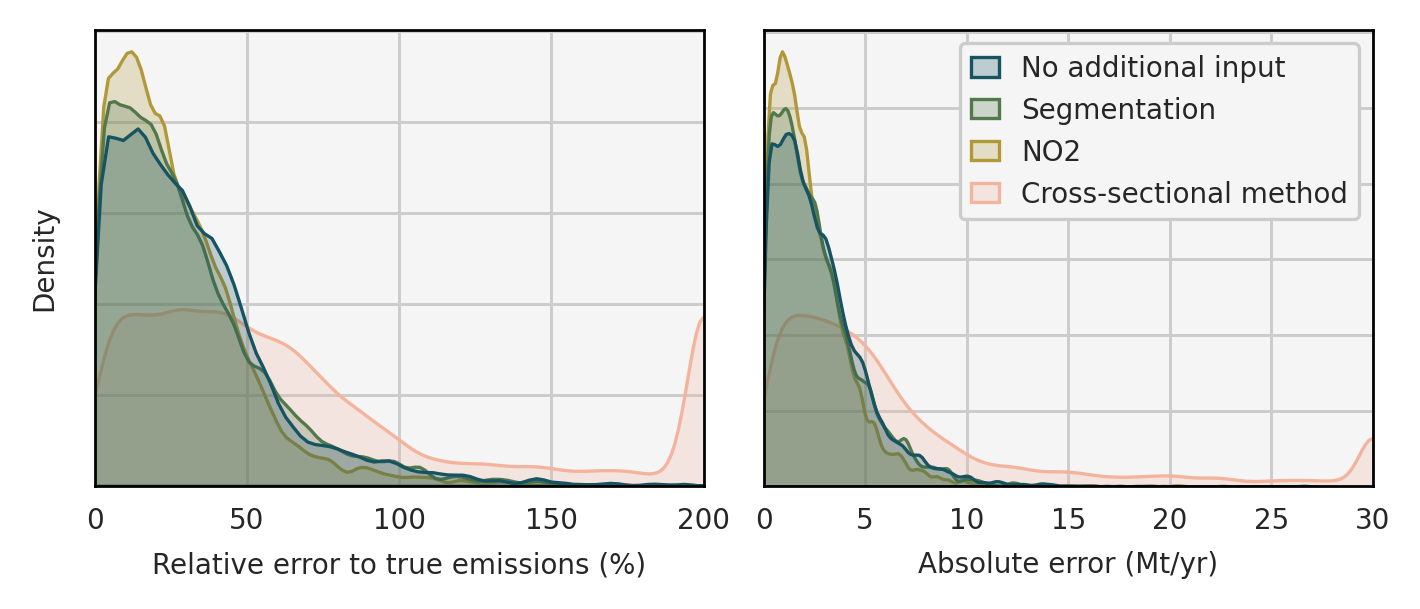

In [19]:
mympf.setMatplotlibParam()
axs = mympf.set_figure_axs(
    1,
    2,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

i_ax = 0
sns.kdeplot(
    df_mape,
    x="Relative error to true emissions (%)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 200)

i_ax = 1
sns.kdeplot(
    df_mae,
    x="Absolute error (Mt/yr)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 30)

for ax in axs:
    ax.grid(linewidth=0.7, alpha=1)
    ax.set_yticklabels([])
for ax in [axs[0]]:
    ax.get_legend().remove()
for ax in [axs[1]]:
    ax.legend_.set_title(None)
    ax.set_ylabel("")

name_fig = os.path.join(dir_plots, f"tur_perf.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

<AxesSubplot: ylabel='Density'>

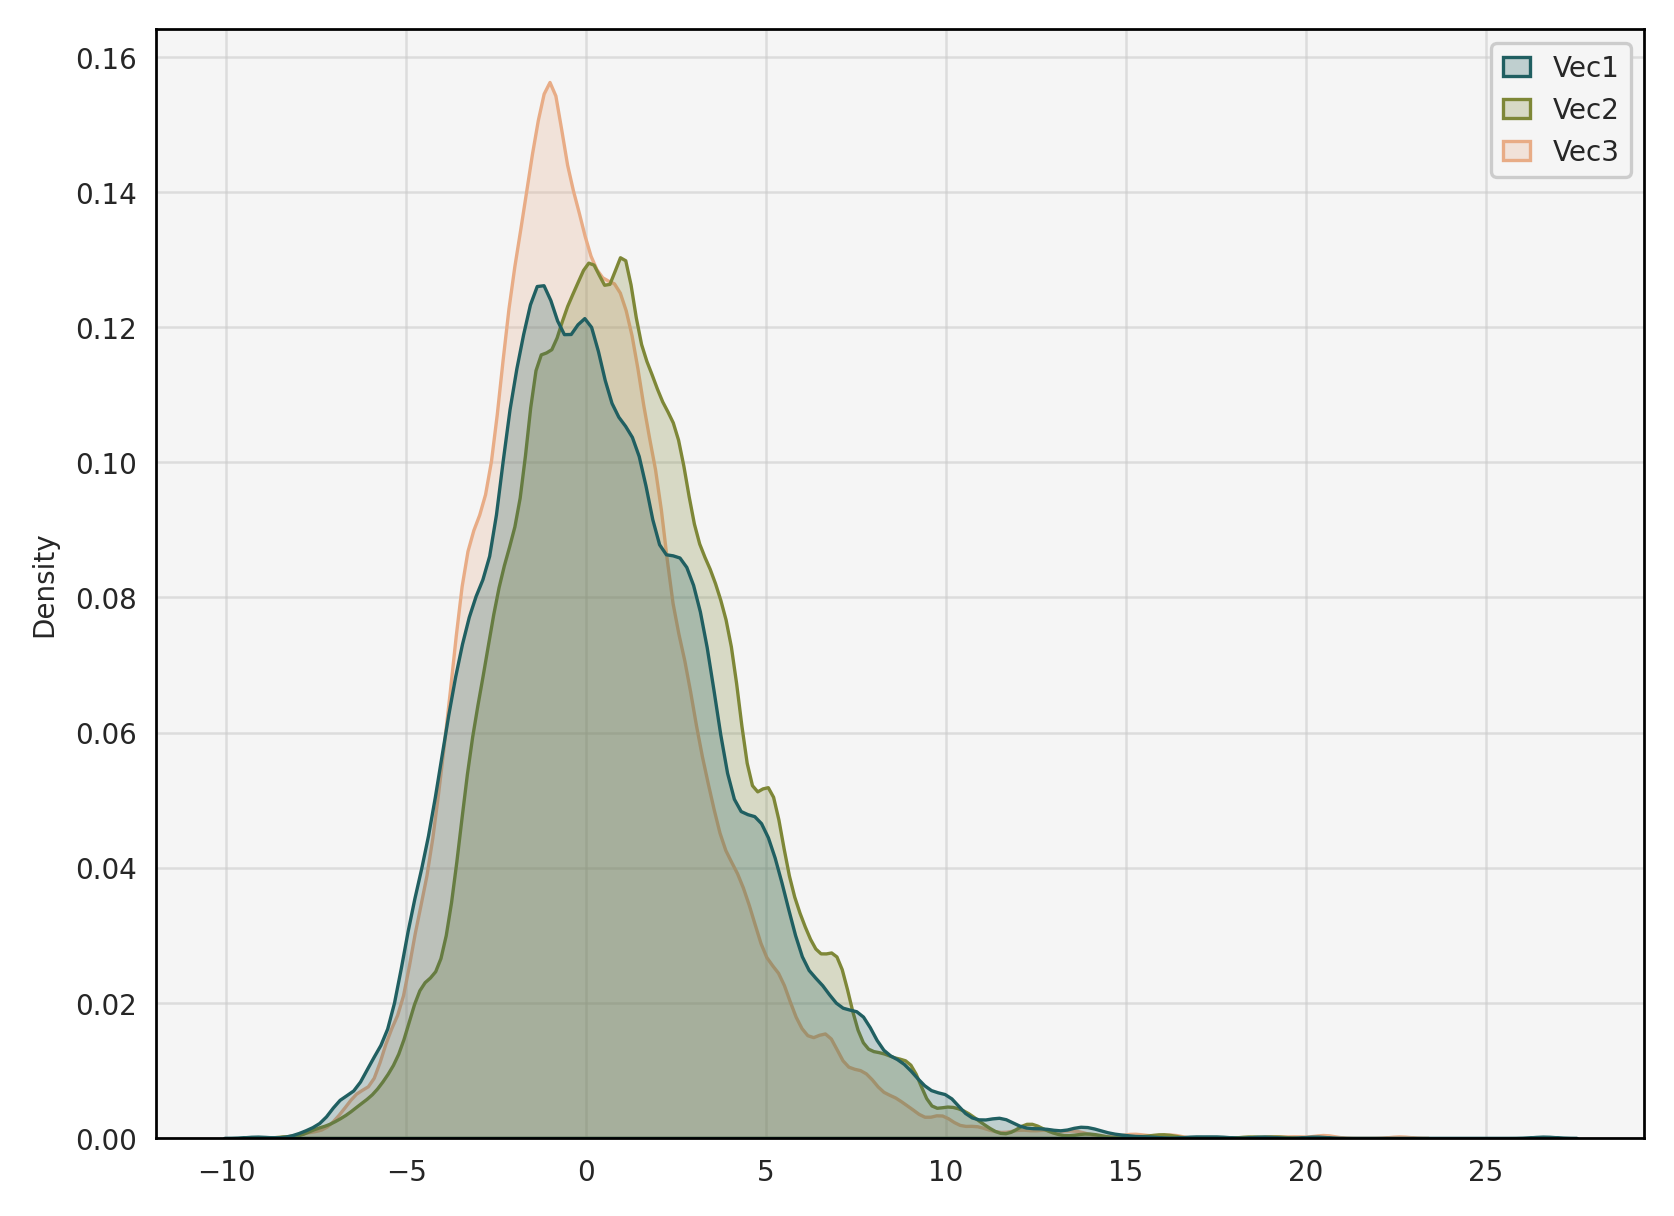

In [20]:
vec1 = np.squeeze(res_tur_none["pred"]) - np.squeeze(res_tur_none["data"].y.eval)
vec2 = np.squeeze(res_tur_seg_pred_no2["pred"]) - np.squeeze(
    res_tur_seg_pred_no2["data"].y.eval
)
vec3 = np.squeeze(res_tur_no2["pred"]) - np.squeeze(res_tur_no2["data"].y.eval)

df = pd.DataFrame({"Vec1": vec1, "Vec2": vec2, "Vec3": vec3})

sns.kdeplot(
    df,
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)

# Lippendorf NO2 experience

In [3]:
name_model = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/best_no2"
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"

In [4]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model),
    path_eval_nc,
)

model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_best.h5"
)

2023-05-22 16:23:01.412244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 16:23:01.945756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14337 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [5]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]), np.median(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]), np.median(metrics["mape"]))

2023-05-22 16:23:03.702584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-22 16:23:04.296526: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


197/197 [==============================] - 3s 6ms/step
mae: 3.1855035 2.6020837
mape: 21.995306 17.529778


In [6]:
no2 = data.ds.no2.values
plume = data.ds.no2_plume.values
scaled_no2 = no2 - plume + 1.5 * plume
data.x.eval[:, :, :, -1] = scaled_no2 + np.random.randn(*scaled_no2.shape) * scaled_no2
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]), np.median(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]), np.median(metrics["mape"]))

197/197 [==============================] - 1s 4ms/step
mae: 3.28514 2.7851715
mape: 21.714544 18.967152


In [26]:
N = 50
all_mape = np.zeros(shape=(N))
scalings = np.linspace(0, 3, N)
for idx, scaling in enumerate(scalings):
    scaled_no2 = no2 - plume + scaling * plume
    data.x.eval[:, :, :, -1] = (
        scaled_no2 + np.random.randn(*scaled_no2.shape) * scaled_no2
    )
    metrics = model_eval.get_inv_metrics_model_on_data(model, data)
    all_mape[idx] = np.median(metrics["mape"])

197/197 [==============================] - 1s 4ms/step


paper-inv/lip_no2_exp.pdf


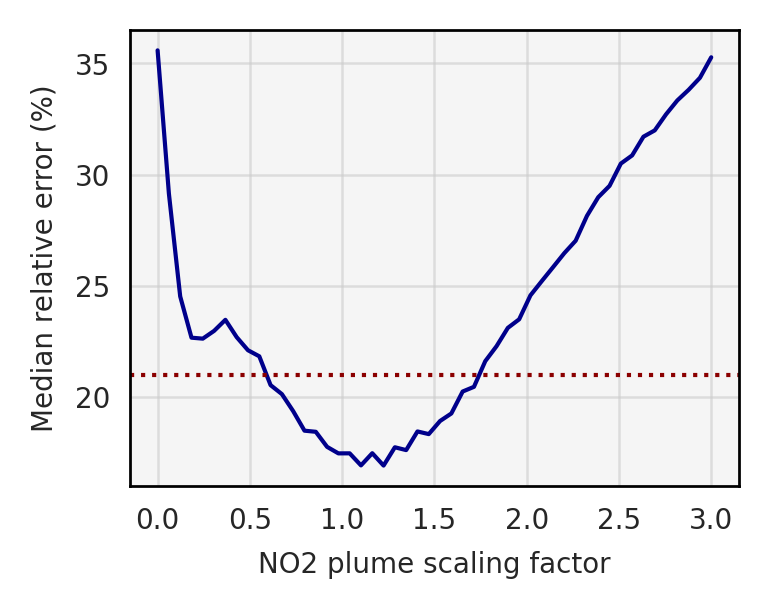

In [47]:
mympf.setMatplotlibParam()
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

sns.lineplot(
    x=scalings,
    y=all_mape,
    color="darkblue",
    markersize=3,
    linewidth=1,
    ax=axs[0],
)

plt.axhline(21, color="darkred", linestyle=":", linewidth=1)

plt.xlabel("NO2 plume scaling factor")
plt.ylabel("Median relative error (%)")

name_fig = os.path.join(dir_plots, f"lip_no2_exp.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

# Boxberg learning curves

In [88]:
df = pd.read_csv("paper-inv/wandb_loss/wandb_losses_3.csv")

In [89]:
def drop_equal_columns(df):
    equal_cols = set()
    num_cols = df.shape[1]

    for i in range(num_cols - 1):
        col1 = df.iloc[:, i]

        for j in range(i + 1, num_cols):
            col2 = df.iloc[:, j]

            if col1.equals(col2):
                equal_cols.add(df.columns[j])

    df = df.drop(equal_cols, axis=1)
    return df


# Drop the columns with equal values
equal_cols = df.columns[df.nunique() == 1]

df = drop_equal_columns(df)

# Fill NA of half of columns with previous value
column_names = [
    "random_None - val_mean_absolute_percentage_error",
    "random_seg - val_mean_absolute_percentage_error",
    "random_no2 - val_mean_absolute_percentage_error",
]
for column_name in column_names:
    df[column_name] = df[column_name].fillna(method="ffill", limit=1)

# Drop NA rows and and change column names
df = df.dropna()
df = df.drop("Step", axis=1)
new_column_names = {
    "random_None - extra_val_metric_0": "None - Test",
    "random_seg - extra_val_metric_0": "Segmentation - Test",
    "random_no2 - extra_val_metric_0": "NO2 - Test",
    "random_None - val_mean_absolute_percentage_error": "None - Valid",
    "random_seg - val_mean_absolute_percentage_error": "Segmentation - Valid",
    "random_no2 - val_mean_absolute_percentage_error": "NO2 - Valid",
}
df = df.rename(columns=new_column_names)
df.index = range(1000)

# Smooth columns
from scipy.ndimage import gaussian_filter1d

sigma = 10
smoothed_df = df.apply(lambda col: gaussian_filter1d(col, sigma))

desired_order = [
    "None - Valid",
    "Segmentation - Valid",
    "NO2 - Valid",
    "None - Test",
    "Segmentation - Test",
    "NO2 - Test",
]

# Reorder the columns
df = df.reindex(columns=desired_order)

paper-inv/box_losses.pdf


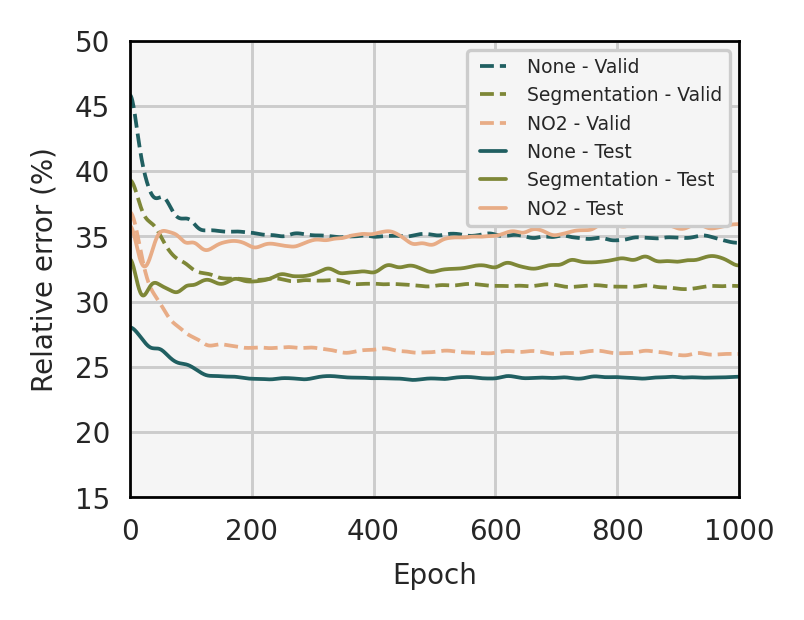

In [90]:
mympf.setMatplotlibParam()
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.35,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

colors = sns.color_palette("cmc.batlowW", int(len(df.columns) / 2))
colors = colors + colors
line_styles = ["dashed", "dashed", "dashed", "-", "-", "-"]

# Plot each column with specified color and line style

for col, color, ls in zip(df.columns, colors, line_styles):
    sns.lineplot(
        data=smoothed_df[col],
        color=color,
        linestyle=ls,
        label=col,
        ax=axs[0],
        linewidth=0.9,
        markers=True,
    )

plt.xlabel("Epoch")
plt.ylabel("Relative error (%)")
plt.ylim(15, 50)
axs[0].grid(linewidth=0.7, alpha=1)
plt.xlim(0, 1000)


plt.legend(loc=1, prop={"size": 4.5}, handlelength=2)

name_fig = os.path.join(dir_plots, f"box_losses.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

# Boxberg reduced ds

In [82]:
path_eval_box = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
path_valid_box = "/libre/dumontj/coco2/dl-input/2km_forBox_4/valid_dataset.nc"
dir_res_box = os.path.join(dir_res, "box/reduced_ds")

In [83]:
all_dir_box = []
for root, dirs, files in os.walk(dir_res_box):
    if "w_best.h5" in files:
        all_dir_box.append(root)

### None

In [85]:
chan_3 = "None"
all_dirs_box_none = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_none.append(dir)

In [86]:
res_box_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_none, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/24
MAE 4.784246 4.088506
MAPE 25.665255 21.98559
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/25
MAE 4.358883 3.7467508
MAPE 23.089552 20.479551
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/26
MAE 5.013678 4.345394
MAPE 26.82153 23.651794
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/27
MAE 4.3740797 3.69917
MAPE 23.37006 20.279898
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/28
MAE 4.528269 3.8905125
MAPE 24.279556 21.1205
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/29
MAE 4.498878 3.925231
MAPE 23.82205 21.324638
19

### no2

In [87]:
chan_3 = "no2"
all_dirs_box_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_no2.append(dir)

In [88]:
res_box_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_no2, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/12
MAE 5.3996463 5.1187305
MAPE 27.860239 27.57235
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/13
MAE 5.908311 5.6719117
MAPE 30.658144 31.020884
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/14
MAE 4.7354336 4.320669
MAPE 24.824638 23.559286
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/15
MAE 4.3728657 3.8940382
MAPE 22.828842 21.114101
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/16
MAE 4.6834197 4.24932
MAPE 24.12388 23.18027
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/17
MAE 5.4543386 5.289608
MAPE 28.15265 28.72

### seg_pred_no2

In [89]:
chan_3 = "seg_pred_no2"
all_dirs_box_seg_pred_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_seg_pred_no2.append(dir)

In [90]:
res_box_seg_pred_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_seg_pred_no2, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/0
MAE 5.7829375 5.4092655
MAPE 30.339298 29.636019
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/1
MAE 6.045153 5.7700233
MAPE 31.556408 31.986675
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/2
MAE 5.8536596 5.3994026
MAPE 30.77635 30.052313
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/3
MAE 5.440141 4.8730392
MAPE 28.546072 26.855427
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/4
MAE 6.1886477 5.6933746
MAPE 32.04746 31.620466
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/5
MAE 4.9577394 4.4884567
MAPE 25.93512 24.7048

### cross-sectional

In [91]:
path_ds = os.path.join("/libre/dumontj/coco2/ddeq/eval", "2km_Box", "cs_emiss_pred.nc")
ds = xr.open_dataset(path_ds)

In [92]:
pred = np.where(ds.cs_emiss_pred.values == -1, np.nan, ds.cs_emiss_pred.values)
idx_notnan = ~np.isnan(pred)
pred = pred[idx_notnan]
pred = np.expand_dims(pred, 1)
y = ds.emiss.values[idx_notnan, 0]
y = np.expand_dims(y, 1)
print("images analysed:", np.sum(idx_notnan) / ds.attrs["N_img"])

metrics_cs = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics_cs["mae"]), np.median(metrics_cs["mae"]))
print("mape:", np.mean(metrics_cs["mape"]), np.median(metrics_cs["mape"]))

metrics_box_cs = metrics_cs

images analysed: 0.8495786293528383
mae: 9.727348490085312 7.730007449884406
mape: 52.86260729526279 41.52475536655409


## Performance histograms

In [93]:
metrics_none = res_box_none["metrics"]
metrics_no2 = res_box_no2["metrics"]
metrics_seg_pred_no2 = res_box_seg_pred_no2["metrics"]
metrics_cs = metrics_box_cs

In [106]:
all_df = model_eval.build_df_perf_inv(
    {
        "none": metrics_none,
        "seg_pred_no2": metrics_seg_pred_no2,
        "no2": metrics_no2,
        "cs": metrics_cs,
    }
)
result = all_df["res"]
df_mae = all_df["df_mae"]
df_mape = all_df["df_mape"]
result_latex = result.rename(columns={result.iloc[:, 0].name[0]: "APE"})
result_latex = result_latex.rename(columns={result.iloc[:, 4].name[0]: "AE"})
result_latex.insert(3, "", "")

In [107]:
print(result_latex.to_latex())

\begin{tabular}{lrrrlrrr}
\toprule
{} & \multicolumn{4}{l}{APE} & \multicolumn{3}{l}{AE} \\
{} &  25\% &  50\% & \multicolumn{2}{l}{75\%} & 25\% & 50\% &  75\% \\
Add. input:            &      &      &      &   &     &     &      \\
\midrule
No additional input    &  9.5 & 20.2 & 33.5 &   & 1.7 & 3.7 &  6.2 \\
Segmentation           & 13.8 & 27.5 & 40.2 &   & 2.5 & 4.9 &  7.7 \\
NO2                    & 13.1 & 23.9 & 34.2 &   & 2.3 & 4.4 &  6.7 \\
Cross-sectional method & 21.7 & 41.5 & 63.5 &   & 3.9 & 7.7 & 12.3 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1375544/1320843946.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_latex.to_latex())


paper-inv/box_reduced_ds_perf.pdf


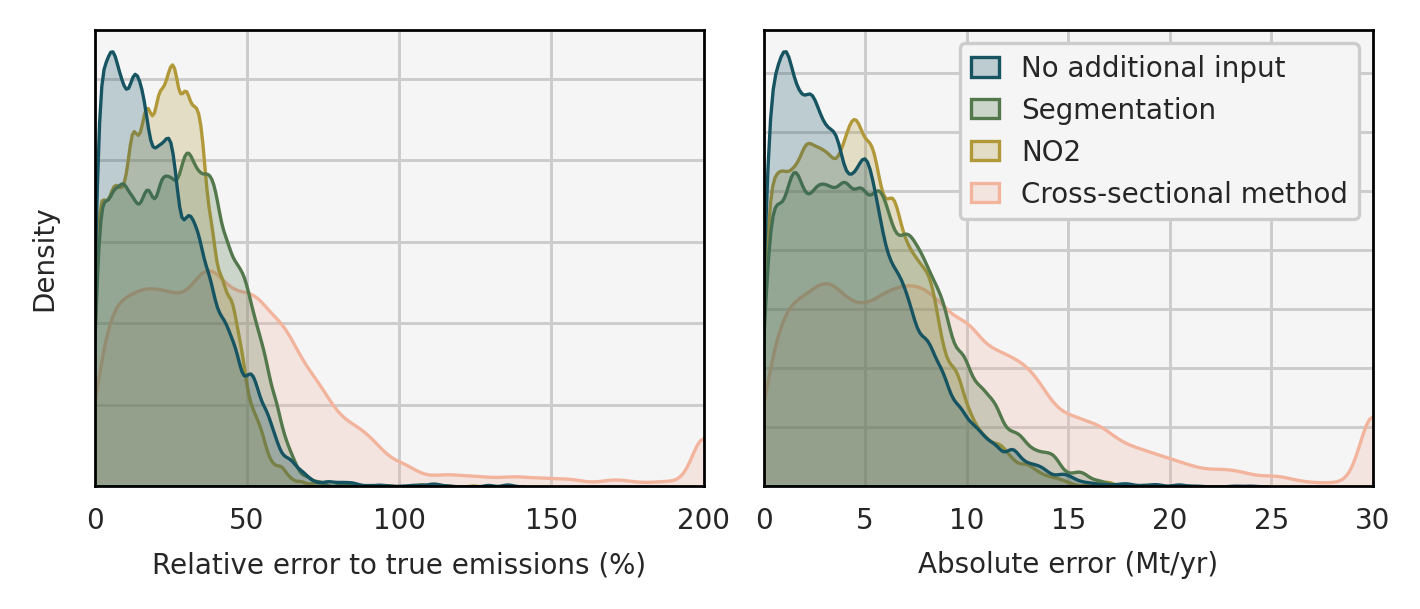

In [104]:
mympf.setMatplotlibParam()
axs = mympf.set_figure_axs(
    1,
    2,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

i_ax = 0
sns.kdeplot(
    df_mape,
    x="Relative error to true emissions (%)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 200)

i_ax = 1
sns.kdeplot(
    df_mae,
    x="Absolute error (Mt/yr)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 30)

for ax in axs:
    ax.grid(linewidth=0.7, alpha=1)
    ax.set_yticklabels([])
for ax in [axs[0]]:
    ax.get_legend().remove()
for ax in [axs[1]]:
    ax.legend_.set_title(None)
    ax.set_ylabel("")

name_fig = os.path.join(dir_plots, f"box_reduced_ds_perf.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

# Gradient based methods

In [12]:
name_model_lip_none = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/best_none"
path_eval_nc_lip = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"

name_model_box_none = (
    "/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/reduced_ds/best_none"
)
path_eval_nc_box = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"

name_model_tur_none = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_none"
name_model_tur_no2 = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_no2"
path_eval_nc_tur = "/libre/dumontj/coco2/dl-input/2km_Tur/train_dataset.nc"

In [56]:
data_lip_none = model_eval.get_data_for_inversion(
    name_model_lip_none,
    path_eval_nc_lip,
)
plume_lip_none = np.expand_dims(data_lip_none.ds.plume.values, -1)
model_lip_none = model_eval.get_inversion_model(name_model_lip_none, name_w="w_last.h5")

data_box_none = model_eval.get_data_for_inversion(
    name_model_box_none,
    path_eval_nc_box,
)
plume_box_none = np.expand_dims(data_box_none.ds.plume.values, -1)
model_box_none = model_eval.get_inversion_model(name_model_box_none, name_w="w_last.h5")

data_tur_none = model_eval.get_data_for_inversion(
    name_model_tur_none,
    path_eval_nc_tur,
)
plume_tur_none = np.expand_dims(data_tur_none.ds.plume.values, -1)
model_tur_none = model_eval.get_inversion_model(name_model_tur_none, name_w="w_last.h5")

data_tur_no2 = model_eval.get_data_for_inversion(
    name_model_tur_no2,
    path_eval_nc_tur,
)
plume_tur_no2 = np.expand_dims(data_tur_no2.ds.plume.values, -1)
model_tur_no2 = model_eval.get_inversion_model(name_model_tur_no2, name_w="w_last.h5")

In [175]:
idx0 = np.random.choice(data_lip_none.ds.attrs["N_img"])
idx0 = 3575
x = tf.cast(data_lip_none.x.eval[idx0 : idx0 + 1], tf.float32)
baseline_tensor = tf.zeros_like(
    tf.cast(data_lip_none.x.eval[idx0 : idx0 + 1], tf.float32)
)
integ_grad_lip_none = model_eval.integrated_gradients(
    model_lip_none, x, baseline_tensor
)

In [176]:
idx1 = np.random.choice(data_box_none.ds.attrs["N_img"])
idx1 = 5168
x = tf.cast(data_box_none.x.eval[idx1 : idx1 + 1], tf.float32)
baseline_tensor = tf.zeros_like(
    tf.cast(data_box_none.x.eval[idx1 : idx1 + 1], tf.float32)
)
integ_grad_box_none = model_eval.integrated_gradients(
    model_box_none, x, baseline_tensor
)

In [177]:
idx2 = np.random.choice(data_tur_none.ds.attrs["N_img"])
idx2 = 4978
x = tf.cast(data_tur_none.x.eval[idx2 : idx2 + 1], tf.float32)
baseline_tensor = tf.zeros_like(
    tf.cast(data_tur_none.x.eval[idx2 : idx2 + 1], tf.float32)
)
integ_grad_tur_none = model_eval.integrated_gradients(
    model_tur_none, x, baseline_tensor
)

In [178]:
idx3 = np.random.choice(data_tur_no2.ds.attrs["N_img"])
idx3 = idx2  # 963, 1860,766, 4978, 5523
baseline_tensor = tf.zeros_like(
    tf.cast(data_tur_no2.x.eval[idx3 : idx3 + 1], tf.float32)
)
x = tf.cast(data_tur_no2.x.eval[idx3 : idx3 + 1], tf.float32)
integ_grad_tur_no2 = model_eval.integrated_gradients(model_tur_no2, x, baseline_tensor)

In [198]:
list_idx = [idx0, idx1, idx2, idx3]
list_data = [data_lip_none, data_box_none, data_tur_none, data_tur_no2]
list_plume = [plume_lip_none, plume_box_none, plume_tur_none, plume_tur_no2]
list_integ_grad = [
    integ_grad_lip_none,
    integ_grad_box_none,
    integ_grad_tur_none,
    integ_grad_tur_no2,
]
list_sources = ["Lippendorf", "Boxberg", "Turow", "Turow (with NO2)"]

paper-inv/integ_gradients.pdf


<Figure size 1920x1440 with 0 Axes>

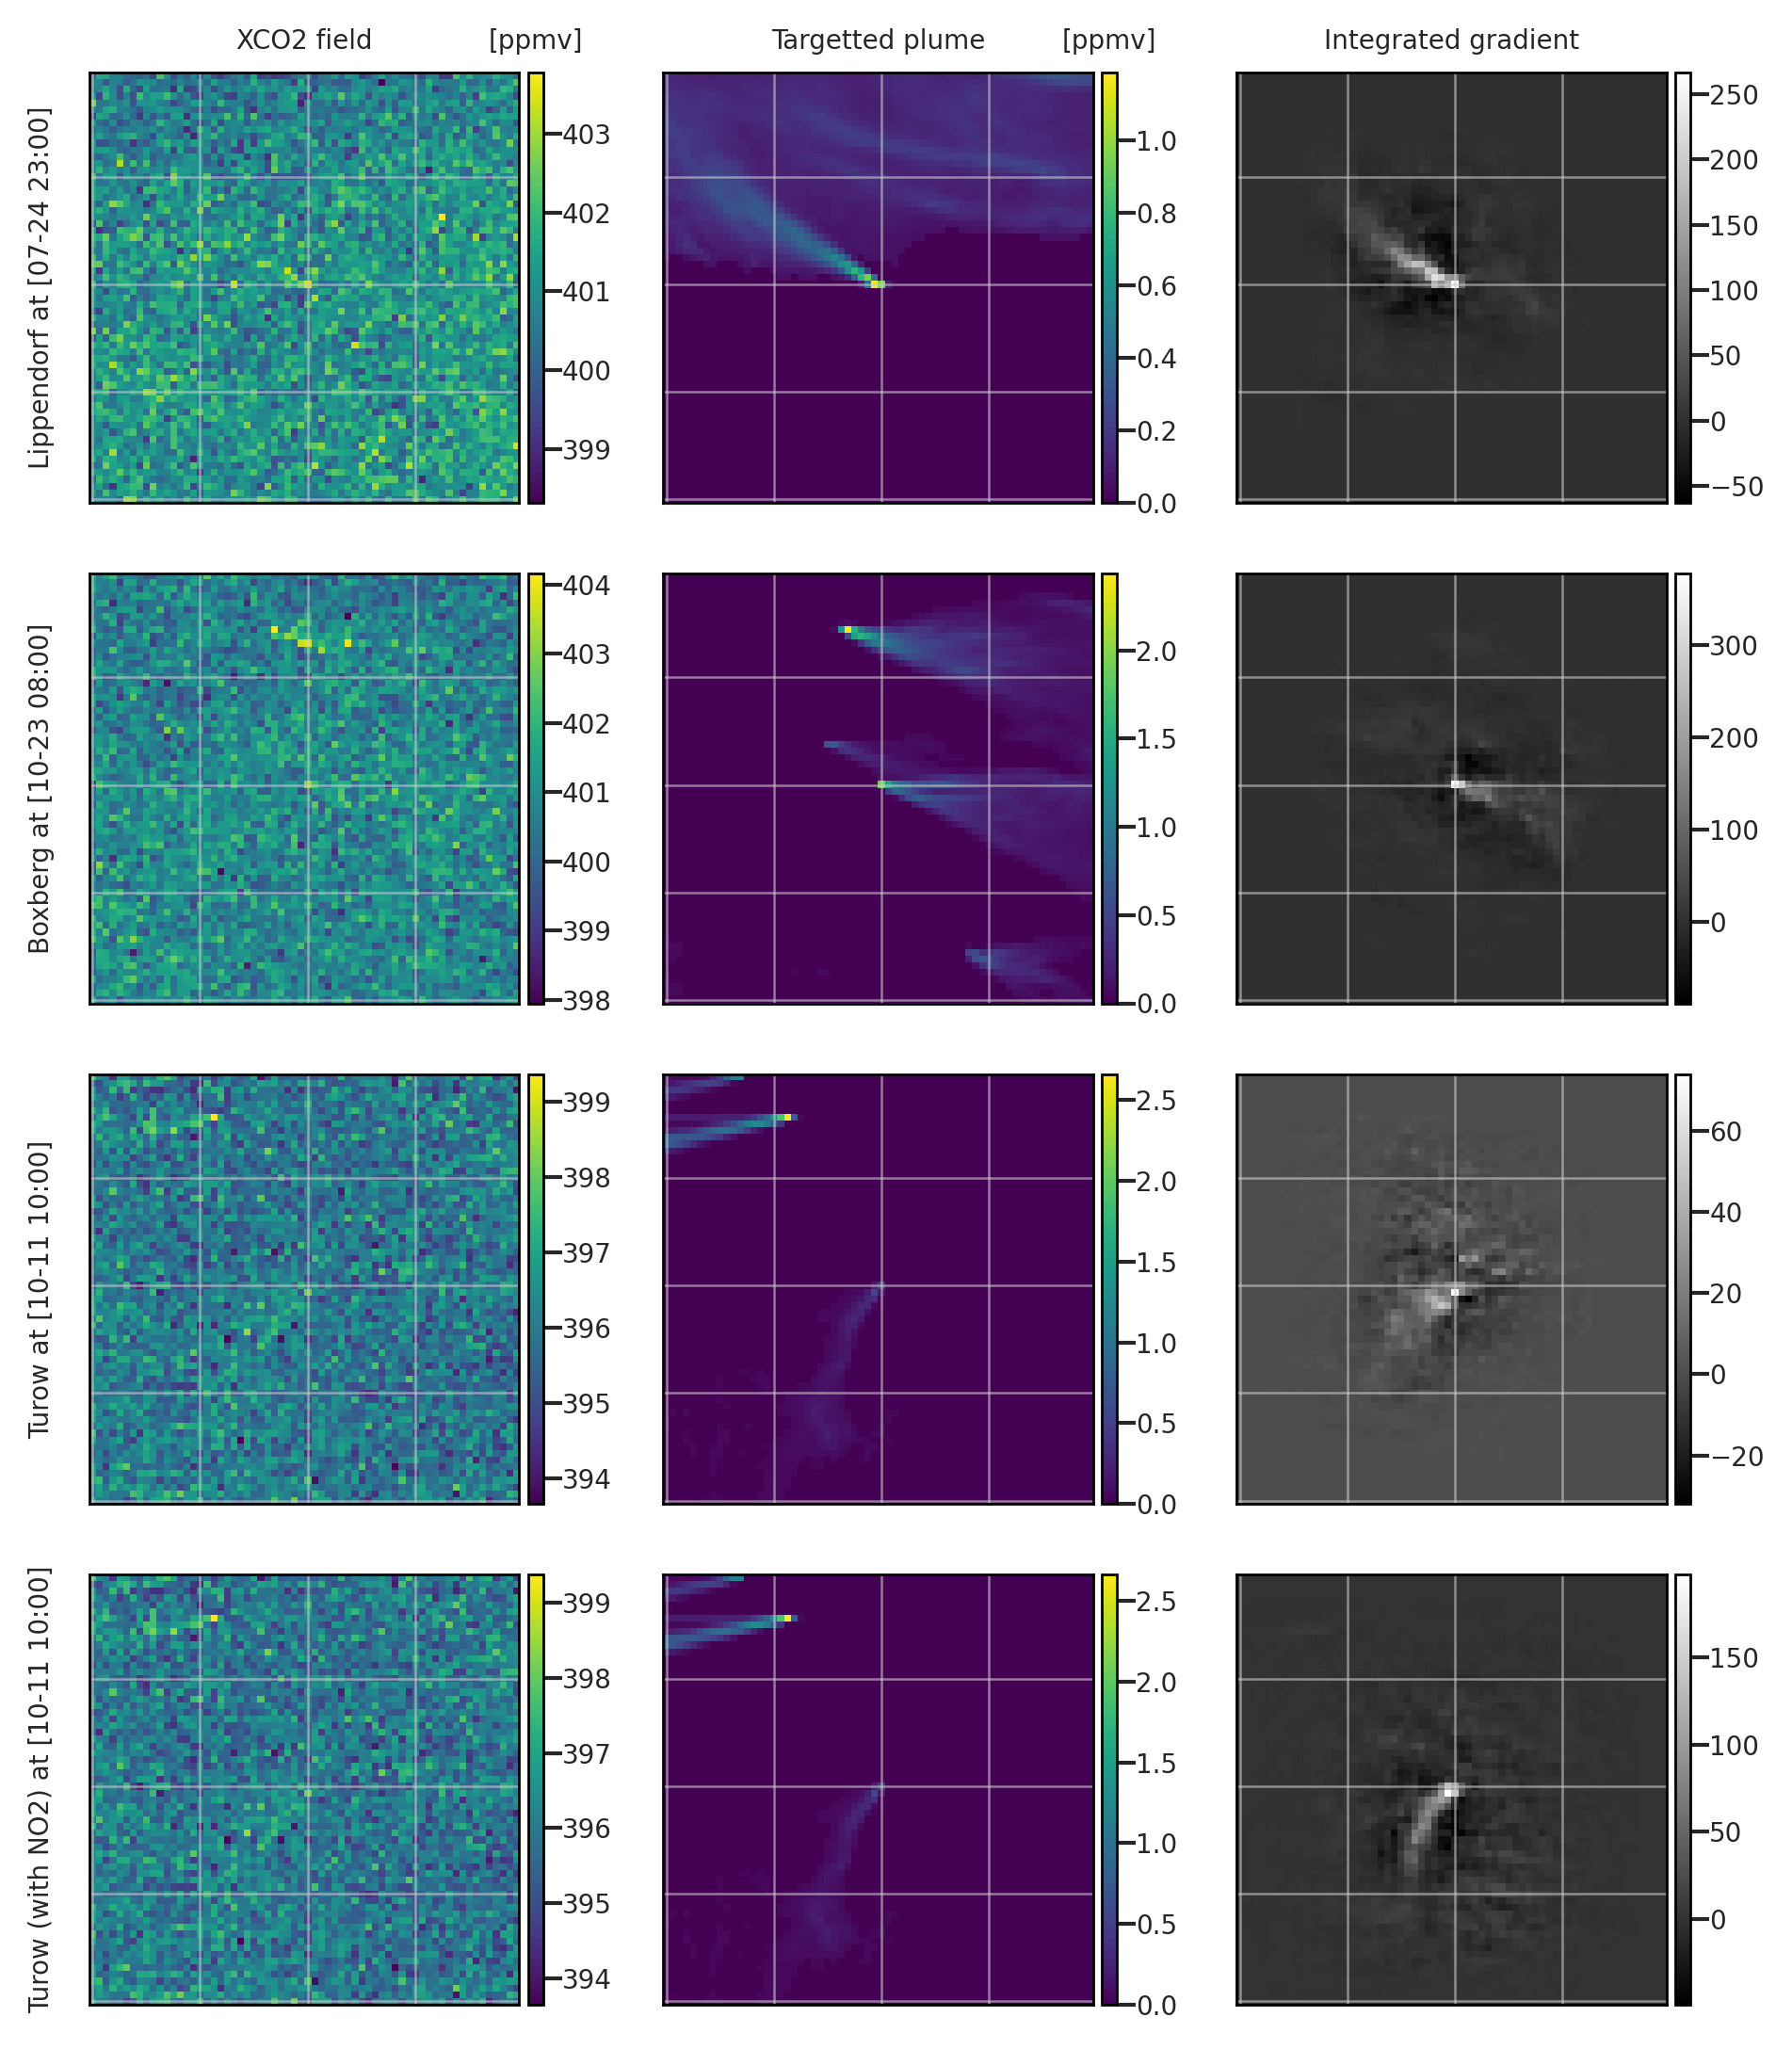

In [201]:
N_idx = 4
N_cols = 3
mympf.setMatplotlibParam()
plt.viridis()
axs = mympf.set_figure_axs(
    N_idx,
    N_cols,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.25,
    pad_w_int=0.001,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

ims = [None] * (N_idx * N_cols)
caxs = [None] * (N_idx * N_cols)
cbars = [None] * (N_idx * N_cols)

Ny = int(data_tur_none.x.eval.shape[1])
Nx = int(data_tur_none.x.eval.shape[2])
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

for i, (idx, data, plume, integ_grad) in enumerate(
    zip(list_idx, list_data, list_plume, list_integ_grad)
):

    cur_row = 0

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(data.x.eval[idx, :, :, 0]), origin="lower")
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(plume[idx, :, :, 0]), origin="lower")
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(
        np.squeeze(integ_grad.numpy()[:, :, 0]), cmap="gray", origin="lower"
    )
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

list_pd_t = []
for (idx, data) in zip(list_idx, list_data):
    list_pd_t.append(pd.Timestamp(data.ds.sel(idx_img=idx).time.values))

for i, (pd_t_idx, source) in enumerate(zip(list_pd_t, list_sources)):
    axs[i * N_cols].set_ylabel(
        f"{source} at [{pd_t_idx.month:02d}-{pd_t_idx.day:02d} {pd_t_idx.hour:02d}:00]"
    )

axs[0].set_title("XCO2 field")
axs[1].set_title("Targetted plume")
axs[2].set_title("Integrated gradient")

cbars[0].ax.set_title("[ppmv]")
cbars[1].ax.set_title("[ppmv]")

name_fig = os.path.join(dir_plots, f"integ_gradients.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

# Feature permutation importance

In [62]:
all_dir_lip = []
for root, dirs, files in os.walk(dir_res_lip):
    if "w_best.h5" in files:
        all_dir_lip.append(root)

chan_3 = "None"
all_dirs_lip_none = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_none.append(dir)

chan_3 = "seg_pred_no2"
all_dirs_lip_seg_pred_no2 = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_seg_pred_no2.append(dir)

chan_3 = "no2"
all_dirs_lip_no2 = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_no2.append(dir)

In [63]:
tf.random.set_seed(10)
np.random.seed(10)

path_eval_lip = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
importance_lip = {}
importance_lip["none"] = [0, 0, 0]
for dir in all_dirs_lip_none:
    importance_lip["none"] = importance_lip[
        "none"
    ] + model_eval.channel_permutation_importance(dir, path_eval_lip)
importance_lip["none"] = importance_lip["none"] / len(all_dirs_lip_none)
importance_lip["none"] = np.insert(importance_lip["none"], 3, np.nan)

importance_lip["seg_pred_no2"] = [0, 0, 0, 0]
for dir in all_dirs_lip_seg_pred_no2:
    importance_lip["seg_pred_no2"] = importance_lip[
        "seg_pred_no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_lip)
importance_lip["seg_pred_no2"] = importance_lip["seg_pred_no2"] / len(
    all_dirs_lip_seg_pred_no2
)

importance_lip["no2"] = [0, 0, 0, 0]
for dir in all_dirs_lip_no2:
    importance_lip["no2"] = importance_lip[
        "no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_lip)
importance_lip["no2"] = importance_lip["no2"] / len(all_dirs_lip_no2)

baseline 24.394564
perm (0,) permuted_loss 43.7771
perm (1,) permuted_loss 36.811077
perm (2,) permuted_loss 28.725735
baseline 25.89295
perm (0,) permuted_loss 46.66748
perm (1,) permuted_loss 38.489693
perm (2,) permuted_loss 31.343958
baseline 24.841219
perm (0,) permuted_loss 44.50705
perm (1,) permuted_loss 37.696724
perm (2,) permuted_loss 29.806086
baseline 26.03492
perm (0,) permuted_loss 46.527798
perm (1,) permuted_loss 38.955315
perm (2,) permuted_loss 31.67796
baseline 32.856293
perm (0,) permuted_loss 46.351646
perm (1,) permuted_loss 41.440445
perm (2,) permuted_loss 37.014225
baseline 29.517035
perm (0,) permuted_loss 44.735703
perm (1,) permuted_loss 39.120575
perm (2,) permuted_loss 33.70878
baseline 23.403343
perm (0,) permuted_loss 42.74864
perm (1,) permuted_loss 35.3693
perm (2,) permuted_loss 28.794584
baseline 25.544783
perm (0,) permuted_loss 51.99689
perm (1,) permuted_loss 40.195335
perm (2,) permuted_loss 29.14227
perm (3,) permuted_loss 41.136536
baseline 27

In [64]:
all_dir_tur = []
for root, dirs, files in os.walk(dir_res_tur):
    if "w_best.h5" in files:
        all_dir_tur.append(root)

chan_3 = "None"
all_dirs_tur_none = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_none.append(dir)

chan_3 = "seg_pred_no2"
all_dirs_tur_seg_pred_no2 = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_seg_pred_no2.append(dir)

chan_3 = "no2"
all_dirs_tur_no2 = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_no2.append(dir)

In [65]:
tf.random.set_seed(10)
np.random.seed(10)

path_eval_tur = "/libre/dumontj/coco2/dl-input/2km_Tur/train_dataset.nc"
importance_tur = {}
importance_tur["none"] = [0, 0, 0]
for dir in all_dirs_tur_none:
    importance_tur["none"] = importance_tur[
        "none"
    ] + model_eval.channel_permutation_importance(dir, path_eval_tur)
importance_tur["none"] = importance_tur["none"] / len(all_dirs_tur_none)
importance_tur["none"] = np.insert(importance_tur["none"], 3, np.nan)

importance_tur["seg_pred_no2"] = [0, 0, 0, 0]
for dir in all_dirs_tur_seg_pred_no2:
    importance_tur["seg_pred_no2"] = importance_tur[
        "seg_pred_no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_tur)
importance_tur["seg_pred_no2"] = importance_tur["seg_pred_no2"] / len(
    all_dirs_tur_seg_pred_no2
)

importance_tur["no2"] = [0, 0, 0, 0]
for dir in all_dirs_tur_no2:
    importance_tur["no2"] = importance_tur[
        "no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_tur)
importance_tur["no2"] = importance_tur["no2"] / len(all_dirs_tur_no2)

baseline 35.78208
perm (0,) permuted_loss 49.24507
perm (1,) permuted_loss 43.278854
perm (2,) permuted_loss 40.171722
baseline 35.689148
perm (0,) permuted_loss 48.42486
perm (1,) permuted_loss 42.455154
perm (2,) permuted_loss 39.390434
baseline 33.097855
perm (0,) permuted_loss 46.513416
perm (1,) permuted_loss 40.19333
perm (2,) permuted_loss 37.09924
baseline 33.93531
perm (0,) permuted_loss 48.522854
perm (1,) permuted_loss 40.62897
perm (2,) permuted_loss 38.229664
baseline 31.480196
perm (0,) permuted_loss 40.044956
perm (1,) permuted_loss 36.46556
perm (2,) permuted_loss 33.095352
baseline 34.175095
perm (0,) permuted_loss 47.523445
perm (1,) permuted_loss 40.37667
perm (2,) permuted_loss 36.57024
perm (3,) permuted_loss 45.35056
baseline 32.521893
perm (0,) permuted_loss 46.385723
perm (1,) permuted_loss 40.51274
perm (2,) permuted_loss 34.689205
perm (3,) permuted_loss 43.86575
baseline 37.345535
perm (0,) permuted_loss 39.926594
perm (1,) permuted_loss 40.056828
perm (2,) p

In [66]:
dir_res_box = os.path.join(dir_res, "box/reduced_ds")
all_dir_box = []
for root, dirs, files in os.walk(dir_res_box):
    if "w_best.h5" in files:
        all_dir_box.append(root)
chan_3 = "None"
all_dirs_box_none = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_none.append(dir)
chan_3 = "seg_pred_no2"
all_dirs_box_seg_pred_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_seg_pred_no2.append(dir)
chan_3 = "no2"
all_dirs_box_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_no2.append(dir)

In [67]:
tf.random.set_seed(10)
np.random.seed(10)

path_eval_box = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
importance_box = {}
importance_box["none"] = [0, 0, 0]
for dir in all_dirs_box_none:
    importance_box["none"] = importance_box[
        "none"
    ] + model_eval.channel_permutation_importance(dir, path_eval_box)
importance_box["none"] = importance_box["none"] / len(all_dirs_box_none)
importance_box["none"] = np.insert(importance_box["none"], 3, np.nan)

importance_box["seg_pred_no2"] = [0, 0, 0, 0]
for dir in all_dirs_box_seg_pred_no2:
    importance_box["seg_pred_no2"] = importance_box[
        "seg_pred_no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_box)
importance_box["seg_pred_no2"] = importance_box["seg_pred_no2"] / len(
    all_dirs_box_seg_pred_no2
)

importance_box["no2"] = [0, 0, 0, 0]
for dir in all_dirs_box_no2:
    importance_box["no2"] = importance_box[
        "no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_box)
importance_box["no2"] = importance_box["no2"] / len(all_dirs_box_no2)

baseline 25.665255
perm (0,) permuted_loss 43.121582
perm (1,) permuted_loss 36.828087
perm (2,) permuted_loss 29.96484
baseline 26.821526
perm (0,) permuted_loss 44.488945
perm (1,) permuted_loss 37.05405
perm (2,) permuted_loss 32.905556
baseline 23.370058
perm (0,) permuted_loss 44.684647
perm (1,) permuted_loss 36.7932
perm (2,) permuted_loss 28.455357
baseline 24.279556
perm (0,) permuted_loss 44.57533
perm (1,) permuted_loss 36.561783
perm (2,) permuted_loss 30.023792
baseline 23.822052
perm (0,) permuted_loss 43.72737
perm (1,) permuted_loss 37.13188
perm (2,) permuted_loss 29.836466
baseline 25.683311
perm (0,) permuted_loss 46.718777
perm (1,) permuted_loss 39.733036
perm (2,) permuted_loss 30.80291
baseline 24.350761
perm (0,) permuted_loss 45.379044
perm (1,) permuted_loss 37.177235
perm (2,) permuted_loss 30.008005
baseline 25.302612
perm (0,) permuted_loss 42.618797
perm (1,) permuted_loss 36.30833
perm (2,) permuted_loss 29.791685
baseline 23.094196
perm (0,) permuted_los

In [72]:
importances = np.zeros((4, 3 * 3))

In [73]:
importances[:, 0] = importance_lip["none"]
importances[:, 1] = importance_lip["seg_pred_no2"]
importances[:, 2] = importance_lip["no2"]

importances[:, 3] = importance_box["none"]
importances[:, 4] = importance_box["seg_pred_no2"]
importances[:, 5] = importance_box["no2"]

importances[:, 6] = importance_tur["none"]
importances[:, 7] = importance_tur["seg_pred_no2"]
importances[:, 8] = importance_tur["no2"]

In [74]:
header = pd.MultiIndex.from_product(
    [["Lippendorf", "Boxberg", "Turow"], ["None", "Segmentation", "NO2"]],
    names=["PP", "Add. input"],
)
df = pd.DataFrame(
    importances, index=["XCO2", "u-wind", "v-wind", "Additional input"], columns=header
)
df.insert(loc=3, column="", value="")
df.insert(loc=7, column=" ", value="")
df

PP               Lippendorf                      Boxberg                       \
Add. input             None Segmentation   NO2      None Segmentation   NO2     
XCO2                  -18.3        -27.6 -32.7     -19.6        -29.5 -34.5     
u-wind                -11.6        -10.4  -3.3     -12.4         -9.7  -4.2     
v-wind                 -4.9         -3.7  -1.8      -5.3         -4.9  -3.0     
Additional input        NaN        -22.7 -30.3       NaN        -28.9 -34.6     

PP               Turow                     
Add. input        None Segmentation   NO2  
XCO2             -12.6         -9.8 -22.7  
u-wind            -6.6         -5.4  -0.9  
v-wind            -3.6         -1.7  -0.6  
Additional input   NaN         -6.9 -21.0

In [75]:
print(df.to_latex())

\begin{tabular}{lrrrlrrrlrrr}
\toprule
PP & \multicolumn{4}{l}{Lippendorf} & \multicolumn{4}{l}{Boxberg} & \multicolumn{3}{l}{Turow} \\
Add. input &       None & Segmentation & \multicolumn{2}{l}{NO2} &    None & Segmentation & \multicolumn{2}{l}{NO2} &  None & Segmentation &   NO2 \\
\midrule
XCO2             &      -18.3 &        -27.6 & -32.7 &   &   -19.6 &        -29.5 & -34.5 &   & -12.6 &         -9.8 & -22.7 \\
u-wind           &      -11.6 &        -10.4 &  -3.3 &   &   -12.4 &         -9.7 &  -4.2 &   &  -6.6 &         -5.4 &  -0.9 \\
v-wind           &       -4.9 &         -3.7 &  -1.8 &   &    -5.3 &         -4.9 &  -3.0 &   &  -3.6 &         -1.7 &  -0.6 \\
Additional input &        NaN &        -22.7 & -30.3 &   &     NaN &        -28.9 & -34.6 &   &   NaN &         -6.9 & -21.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1468915/2350534188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


In [28]:
model_eval.channel_permutation_importance(
    os.path.join(dir_res_tur, "best_seg_pred_no2"), path_eval_tur, size_max_combi=2
)

baseline 31.11224
perm (0,) permuted_loss 35.75562
perm (1,) permuted_loss 32.5679
perm (2,) permuted_loss 32.459827
perm (3,) permuted_loss 31.792624
perm (0, 1) permuted_loss 36.372143
perm (0, 2) permuted_loss 36.393974
perm (0, 3) permuted_loss 37.141262
perm (1, 2) permuted_loss 34.47638
perm (1, 3) permuted_loss 33.460392
perm (2, 3) permuted_loss 33.522663


array([-4.64337921, -1.45566177, -1.34758759, -0.68038368, -5.25990295,
       -5.28173447, -6.02902222, -3.36413956, -2.34815216, -2.41042328])

In [23]:
model_eval.channel_permutation_importance(
    os.path.join(dir_res_tur, "1"), path_eval_tur, size_max_combi=2
)

baseline 34.175095
perm (0,) permuted_loss 47.617825
perm (1,) permuted_loss 40.695698
perm (2,) permuted_loss 36.982113
perm (3,) permuted_loss 45.534355
perm (0, 1) permuted_loss 48.04633
perm (0, 2) permuted_loss 48.124393
perm (0, 3) permuted_loss 48.818542
perm (1, 2) permuted_loss 43.374332
perm (1, 3) permuted_loss 47.09039
perm (2, 3) permuted_loss 45.900787


array([-13.44272995,  -6.52060318,  -2.80701828, -11.35926056,
       -13.87123489, -13.94929886, -14.64344788,  -9.19923782,
       -12.91529465, -11.72569275])

In [24]:
model_eval.channel_permutation_importance(
    os.path.join(dir_res_tur, "2"), path_eval_tur, size_max_combi=2
)

baseline 32.521893
perm (0,) permuted_loss 47.49724
perm (1,) permuted_loss 40.02217
perm (2,) permuted_loss 34.194313
perm (3,) permuted_loss 44.15789
perm (0, 1) permuted_loss 48.541794
perm (0, 2) permuted_loss 47.725998
perm (0, 3) permuted_loss 48.997616
perm (1, 2) permuted_loss 42.135803
perm (1, 3) permuted_loss 46.520145
perm (2, 3) permuted_loss 44.769917


array([-14.97534561,  -7.50027847,  -1.6724205 , -11.63599777,
       -16.01990128, -15.20410538, -16.47572327,  -9.61391068,
       -13.99825287, -12.24802399])

In [25]:
model_eval.channel_permutation_importance(
    os.path.join(dir_res_tur, "3"), path_eval_tur, size_max_combi=2
)

baseline 37.345535
perm (0,) permuted_loss 39.274055
perm (1,) permuted_loss 39.203297
perm (2,) permuted_loss 37.552135
perm (3,) permuted_loss 36.991055
perm (0, 1) permuted_loss 40.08137
perm (0, 2) permuted_loss 39.542496
perm (0, 3) permuted_loss 40.196865
perm (1, 2) permuted_loss 39.76032
perm (1, 3) permuted_loss 38.55487
perm (2, 3) permuted_loss 36.696644


array([-1.9285202 , -1.85776138, -0.20660019,  0.35448074, -2.73583603,
       -2.19696045, -2.8513298 , -2.41478348, -1.20933533,  0.64889145])